# Introducción

Este notebook forma parte del Trabajo de Fin de Máster en Inteligencia Artificial, desarrollado en colaboración con la fintech MytripleA. El objetivo principal es implementar un sistema de análisis de riesgo crediticio en escenarios con small data, integrando técnicas modernas de inteligencia artificial, generación de datos sintéticos y buenas prácticas de MLOps.

La motivación central de este proyecto surge de una necesidad real en el sector financiero: evaluar el riesgo crediticio de pequeñas y medianas empresas con volúmenes de datos limitados y desbalanceados. En estos casos, los enfoques tradicionales pierden precisión, por lo que se propone un pipeline automatizado, reproducible y explicable, capaz de entrenar modelos robustos incluso en condiciones adversas.

En este cuaderno y en el cuaderno llamado "EDA" se presentan las distintas fases del pipeline, que incluyen:

- Preprocesamiento y exploración de datos

- Generación de datos sintéticos con SMOTE y CTGAN

- Entrenamiento y evaluación de modelos con GridSearchCV

- Análisis de explicabilidad con SHAP

### Anonimización de datos

Este fragmento de código tiene como propósito verificar la unicidad de los identificadores de empresa en un dataset y, posteriormente, anonimizar dichos identificadores para proteger la confidencialidad de la información. Primero, se carga un archivo Parquet con datos empresariales y se analiza si la columna codigo_empresa contiene duplicados, mostrando el número de valores únicos y el total de registros. Luego, para garantizar la anonimización, se reemplazan los identificadores originales por un conjunto de IDs numéricos secuenciales generados mediante pd.factorize, eliminando así cualquier traza directa con los datos reales. Finalmente, se guarda el resultado como un nuevo archivo Parquet listo para su uso en contextos donde la privacidad de los datos es crítica, como en entornos regulatorios o colaboraciones externas.

In [ ]:
'''import pandas as pd

# Cargar el dataset
df = pd.read_parquet('companies_T.parquet')

# 1. Ver si hay valores duplicados en la columna 'codigo_empresa'
duplicados = df['codigo_empresa'].duplicated().any()
print("¿Hay valores duplicados en 'codigo_empresa'? ->", duplicados)

# Ver cuántos valores únicos hay
print("Valores únicos:", df['codigo_empresa'].nunique())
print("Total de registros:", len(df))

# 2. Anonimizar la columna 'codigo_empresa' asignando IDs secuenciales no rastreables
df['codigo_empresa'] = pd.factorize(df['codigo_empresa'])[0] + 1

# Guardar el nuevo 
df.to_parquet('companies_T_anon.parquet', index=False)

'''

Este bloque de código importa todas las librerías necesarias para construir un pipeline de credit scoring en un entorno de small data, integrando técnicas de aprendizaje automático, balanceo de clases y generación de datos sintéticos. Se incluyen librerías para: manipulación y preprocesamiento de datos (pandas, numpy, SimpleImputer, StandardScaler, MinMaxScaler), visualización (matplotlib), evaluación de modelos (confusion_matrix, classification_report, etc.), y modelado supervisado con múltiples algoritmos (LogisticRegression, RandomForestClassifier, XGBClassifier, etc.). También se incorporan herramientas específicas como CTGAN para generación de datos sintéticos, SMOTE para sobremuestreo, GridSearchCV para ajuste de hiperparámetros y joblib para guardar modelos. La inclusión de torch y random permite controlar la semilla aleatoria para garantizar la reproducibilidad en entornos experimentales. En conjunto, este bloque establece la base técnica para el desarrollo y experimentación de modelos robustos y explicables en entornos de datos reducidos.

In [1]:
from ctgan import CTGAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
import os
from glob import glob
import re
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import joblib
import random
import torch
import math


Este bloque de código agrupa funciones esenciales para el desarrollo de un pipeline robusto en contextos de small data y credit scoring, integrando generación de datos sintéticos, preprocesamiento, selección de variables, visualización y evaluación de modelos. En primer lugar, se fija una semilla global para garantizar reproducibilidad en experimentos con random, numpy y torch. La función generar_datos_ctgan permite ampliar datasets desbalanceados mediante CTGAN, combinando técnicas de imputación, codificación y escalado, y devolviendo un dataset enriquecido. Por otro lado, se incluyen funciones de visualización para representar matrices de confusión, curvas ROC y la importancia de variables, facilitando la interpretabilidad del modelo. Además, se provee una herramienta (generar_tabla_comparativa_f1) que resume y compara métricas de distintos modelos y escenarios. Las funciones preprocesar_datos y seleccionar_variables realizan un tratamiento sistemático del dataset: imputación, normalización, detección de outliers, y eliminación de variables con baja varianza o alta colinealidad, lo cual es crucial para evitar sobreajuste y mejorar la calidad de los modelos entrenados. En conjunto, este bloque constituye la base funcional y metodológica del pipeline de experimentación, siguiendo las buenas prácticas de MLOps.

In [2]:
random.seed(1)
np.random.seed(1)

def fijar_seed(seed=1):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def generar_datos_ctgan(X, y, target_col="target_bin", n_samples=300, epochs=300):
    fijar_seed(1)
    df_ctgan = X.reset_index(drop=True).copy()
    y = y.reset_index(drop=True)

    # Eliminar columnas datetime
    datetime_cols = df_ctgan.select_dtypes(include="datetime64").columns
    if len(datetime_cols) > 0:
        print(f"Eliminando columnas datetime: {list(datetime_cols)}")
        df_ctgan.drop(columns=datetime_cols, inplace=True)

    # Imputar nulos
    imputer = SimpleImputer(strategy="median")
    df_ctgan[df_ctgan.columns] = imputer.fit_transform(df_ctgan)

    # Añadir target
    df_ctgan[target_col] = y

    # Columnas categóricas
    discrete_cols = df_ctgan.select_dtypes(include='object').columns.tolist()
    if target_col not in discrete_cols:
        discrete_cols.append(target_col)

    # CTGAN
    ctgan = CTGAN(epochs=epochs)
    ctgan.fit(df_ctgan, discrete_columns=discrete_cols)

    synthetic_data = ctgan.sample(n_samples)
    synthetic_data[target_col] = synthetic_data[target_col].round().fillna(0).astype(int)

    print("Distribución de clase sintética:")
    print(synthetic_data[target_col].value_counts())

    df_combined = pd.concat([df_ctgan, synthetic_data], ignore_index=True)
    X_combined = df_combined.drop(columns=[target_col])
    y_combined = df_combined[target_col].fillna(0).astype(int)

    # One-hot encoding y escalado
    X_combined = pd.get_dummies(X_combined, drop_first=True)
    scaler = StandardScaler()
    X_combined_scaled = scaler.fit_transform(X_combined)

    return X_combined_scaled, y_combined

def plot_confusion_matrix(y_true, y_pred, model_name, suffix=""):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(cmap="Blues")
    plt.title(f"Matriz de Confusión - {model_name}")
    plt.show()


from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_prob, model_name, suffix=""):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.title(f"Curva ROC - {model_name}")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.legend()
    plt.show()


def plot_feature_importance(model, feature_names, model_name, suffix=""):
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
        sorted_idx = importances.argsort()[::-1]
        plt.figure(figsize=(10, 6))
        plt.bar(range(len(importances)), importances[sorted_idx])
        plt.xticks(range(len(importances)), 
                   [feature_names[i] for i in sorted_idx], 
                   rotation=90)
        plt.title(f"Importancia de Variables - {model_name}")
        plt.tight_layout()
        plt.show()


def generar_tabla_comparativa_f1(lista_resultados):
    import pandas as pd

    df_all = pd.DataFrame(lista_resultados)

    if df_all.empty:
        print("No hay resultados para mostrar.")
        return None

    tabla = df_all.pivot_table(
        index="modelo",
        columns="dataset",
        values="f1_score",
        aggfunc="max"
    )

    display(tabla.round(2))

    print("\n Mejor modelo por dataset:")
    for dataset in tabla.columns:
        mejor_modelo = tabla[dataset].idxmax()
        f1 = tabla[dataset].max()
        print(f"- {dataset}: {mejor_modelo} (F1 = {f1:.2f})")

    mejor_global = tabla.stack().idxmax()
    mejor_modelo_global, mejor_dataset_global = mejor_global
    f1_global = tabla.loc[mejor_modelo_global, mejor_dataset_global]
    print(f"\n Mejor modelo global: {mejor_modelo_global} con {mejor_dataset_global} (F1 = {f1_global:.2f})")

    return tabla


def preprocesar_datos(
    df,
    eliminar_columnas_alta_nulos=True,
    umbral_nulos=0.65,
    imputacion=True,
    estrategia_imputacion='median',
    tratar_outliers=True,
    metodo_outliers='IQR',
    escalar=True,
    metodo_escalado='standard'
):
    df = df.copy()

    df['grade_code'] = pd.to_numeric(df['grade_code'], errors='coerce')
    df = df[df['grade_code'].notna()]
    df['target_bin'] = df['grade_code'].astype(int).apply(lambda x: 1 if x >= 7 else 0)

    if 'fecha_constitucion' in df.columns:
        df = df.drop(columns='fecha_constitucion')

    if 'codigo_empresa' in df.columns:
        df = df.drop(columns='codigo_empresa')

    if eliminar_columnas_alta_nulos:
        df = df.loc[:, df.isnull().mean() < umbral_nulos]

    if imputacion:
        imp = SimpleImputer(strategy=estrategia_imputacion)
        cols_target = ['grade_code', 'target_bin']
        numeric_cols = df.select_dtypes(include=['number']).columns
        numeric_cols = [col for col in numeric_cols if col not in cols_target]
        df[numeric_cols] = imp.fit_transform(df[numeric_cols])

    if tratar_outliers:
        numeric_cols = df.select_dtypes(include=['number']).columns
        numeric_cols = [col for col in numeric_cols if col not in ['grade_code', 'target_bin']]
        for col in numeric_cols:
            if metodo_outliers == 'IQR':
                Q1 = df[col].quantile(0.25)
                Q3 = df[col].quantile(0.75)
                IQR = Q3 - Q1
                lower = Q1 - 1.5 * IQR
                upper = Q3 + 1.5 * IQR
                df[col] = np.clip(df[col], lower, upper)
            elif metodo_outliers == 'zscore':
                z = (df[col] - df[col].mean()) / df[col].std()
                df[col] = np.where(z > 3, df[col].mean(), df[col])
                df[col] = np.where(z < -3, df[col].mean(), df[col])

    if escalar:
        scaler = StandardScaler() if metodo_escalado == 'standard' else MinMaxScaler()
        numeric_cols = df.select_dtypes(include=['number']).columns
        numeric_cols = [col for col in numeric_cols if col not in ['grade_code', 'target_bin']]
        df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

    return df


def seleccionar_variables(df, target_col, umbral_varianza=0.01, umbral_correlacion=0.95):
    df = df.copy()

    posibles_targets = ['grade_code', 'target_bin', 'grade_group']
    posibles_targets.remove(target_col)
    df = df.drop(columns=[col for col in posibles_targets if col in df.columns])

    columnas_numericas = df.select_dtypes(include=[np.number]).columns.tolist()
    if target_col not in columnas_numericas:
        columnas_numericas.append(target_col)
    df = df[columnas_numericas]

    selector = VarianceThreshold(threshold=umbral_varianza)
    features = df.drop(columns=[target_col])
    selector.fit(features)
    columnas_baja_varianza = features.columns[~selector.get_support()]
    print(f"Eliminando por baja varianza: {list(columnas_baja_varianza)}")
    df = df.drop(columns=columnas_baja_varianza)

    corr_matrix = df.drop(columns=[target_col]).corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    columnas_alta_correlacion = [col for col in upper.columns if any(upper[col] > umbral_correlacion)]
    print(f"Eliminando por alta correlacion: {columnas_alta_correlacion}")
    df = df.drop(columns=columnas_alta_correlacion)

    return df


Este bloque constituye el núcleo experimental del pipeline de evaluación de modelos en escenarios de small data. La función entrenar_modelos se encarga de entrenar y comparar múltiples algoritmos de clasificación supervisada (como Logistic Regression, Random Forest, XGBoost o MLP) usando GridSearchCV para la optimización de hiperparámetros y validación cruzada. Internamente, se separan los datos en entrenamiento y prueba, se entrena cada modelo, se calculan métricas clave (accuracy, precision, recall, f1-score) y se generan gráficos de evaluación (matriz de confusión, curva ROC, importancia de variables) para cada caso, facilitando la interpretación y comparación visual en notebooks.

Además, se contempla el uso de distintas variantes del conjunto de datos: datos originales, sobremuestreados con SMOTE, generados con CTGAN y combinaciones de ambos métodos. Esto permite analizar el impacto real de las técnicas de enriquecimiento en el rendimiento de los modelos. La ejecución principal (if _name_ == "_main_") carga el dataset anonimizado, realiza el preprocesamiento y la selección de variables, y ejecuta el pipeline completo en todos los escenarios mencionados. Se genera una tabla resumen de resultados mediante generar_tabla_comparativa_f1, que destaca el mejor modelo por escenario y el mejor modelo global. Esta estructura modular y automatizada está alineada con buenas prácticas de MLOps, y permite iterar, escalar y analizar el sistema con trazabilidad completa.

In [3]:
def entrenar_modelos(X, y, dataset_name='Original', scoring='f1', test_size=0.2, random_state=1):
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X, columns=[f"feature_{i}" for i in range(X.shape[1])])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=random_state)

    parametros_modelos = {
        'LogisticRegression': {'C': [0.1, 1.0, 10.0]},
        'RandomForest': {'n_estimators': [100, 200], 'max_depth': [None, 10]},
        'XGBoost': {'n_estimators': [100, 200], 'max_depth': [3, 6]},
        'GradientBoosting': {'n_estimators': [100, 200], 'learning_rate': [0.1, 0.05]},
        'KNN': {'n_neighbors': [3, 5, 7]},
        'SVC': {'C': [0.1, 1.0], 'kernel': ['linear', 'rbf']},
        'NaiveBayes': {},
        'MLP': {'hidden_layer_sizes': [(50,), (100,)], 'alpha': [0.0001, 0.001]}
    }

    modelos = {
        'LogisticRegression': LogisticRegression(max_iter=1000, random_state=1),
        'RandomForest': RandomForestClassifier(random_state=1),
        'XGBoost': XGBClassifier(eval_metric='logloss',random_state=1),
        'GradientBoosting': GradientBoostingClassifier(random_state=1),
        'KNN': KNeighborsClassifier(),
        'SVC': SVC(probability=True, random_state=1),
        'NaiveBayes': GaussianNB(),
        'MLP': MLPClassifier(max_iter=1000, random_state=1)
    }

    resultados = []

    for nombre, modelo in modelos.items():
        print(f"\n Entrenando {nombre} con {dataset_name}")
        try:
            params = parametros_modelos.get(nombre, {})
            grid = GridSearchCV(modelo, params, cv=3, scoring=scoring, n_jobs=-1)
            grid.fit(X_train, y_train)
            best_model = grid.best_estimator_
            y_pred = best_model.predict(X_test)

            acc = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            prec = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)

            resultados.append({
                "dataset": dataset_name,
                "modelo": nombre,
                "accuracy": acc,
                "f1_score": f1,
                "precision": prec,
                "recall": recall
            })

            # Probabilidades para ROC
            if hasattr(best_model, "predict_proba"):
                y_proba = best_model.predict_proba(X_test)[:, 1]
            elif hasattr(best_model, "decision_function"):
                y_proba = best_model.decision_function(X_test)
            else:
                y_proba = None

            # Gráficos en notebook
            plot_confusion_matrix(y_test, y_pred, nombre)
            if y_proba is not None:
                plot_roc_curve(y_test, y_proba, nombre)
            if hasattr(best_model, "feature_importances_"):
                plot_feature_importance(best_model, X.columns, nombre)

            print(classification_report(y_test, y_pred))

        except Exception as e:
            print(f" Error con {nombre}: {repr(e)}")

    # Mostrar resultados en DataFrame
    df_resultados = pd.DataFrame(resultados)
    display(df_resultados.sort_values(by="f1_score", ascending=False))

    # Mejor modelo del dataset
    mejor_resultado = max(resultados, key=lambda x: x["f1_score"])
    print(f"\n Mejor modelo para {dataset_name}: {mejor_resultado['modelo']} (F1={mejor_resultado['f1_score']:.2f})")

    return resultados




Eliminando por baja varianza: ['cash_flow_antes_var']
Eliminando por alta correlacion: []
 Datos originales

 Entrenando LogisticRegression con Original


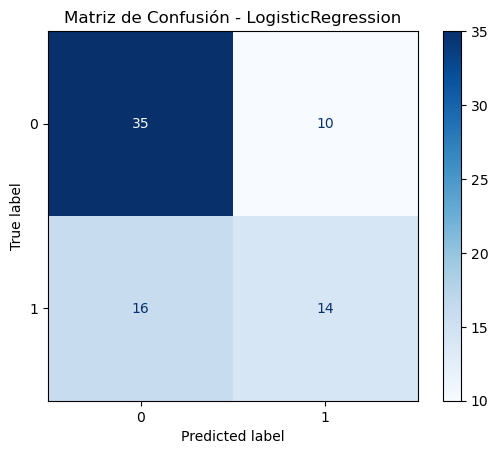

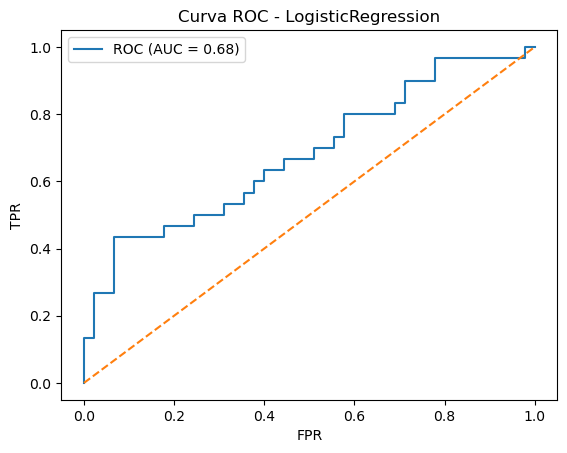

              precision    recall  f1-score   support

           0       0.69      0.78      0.73        45
           1       0.58      0.47      0.52        30

    accuracy                           0.65        75
   macro avg       0.63      0.62      0.62        75
weighted avg       0.65      0.65      0.64        75


 Entrenando RandomForest con Original


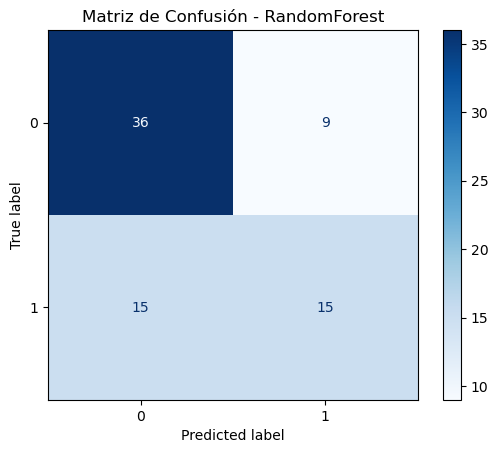

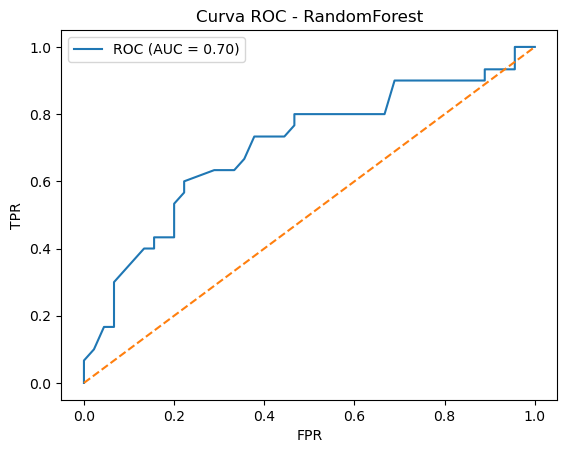

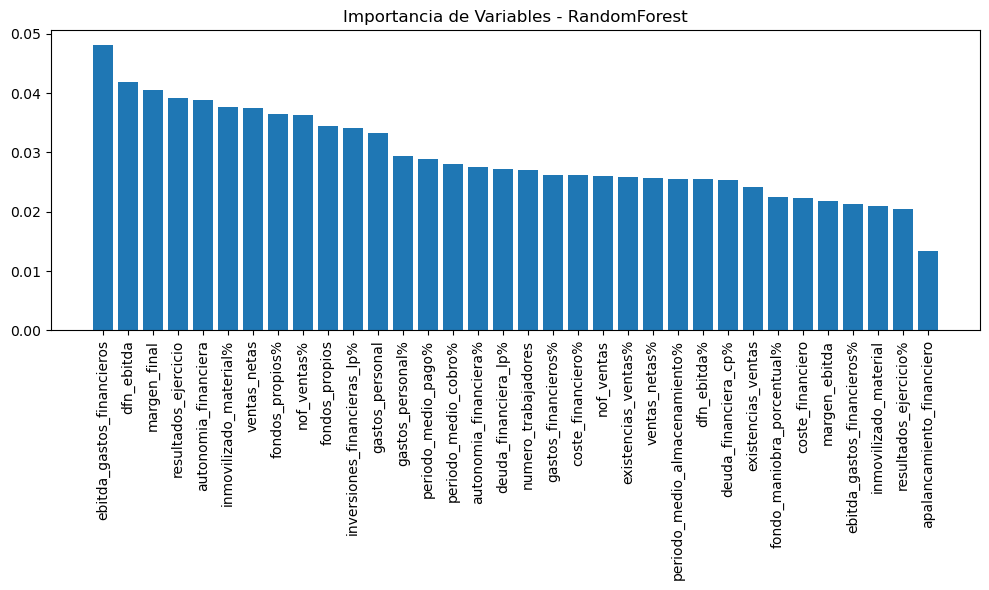

              precision    recall  f1-score   support

           0       0.71      0.80      0.75        45
           1       0.62      0.50      0.56        30

    accuracy                           0.68        75
   macro avg       0.67      0.65      0.65        75
weighted avg       0.67      0.68      0.67        75


 Entrenando XGBoost con Original


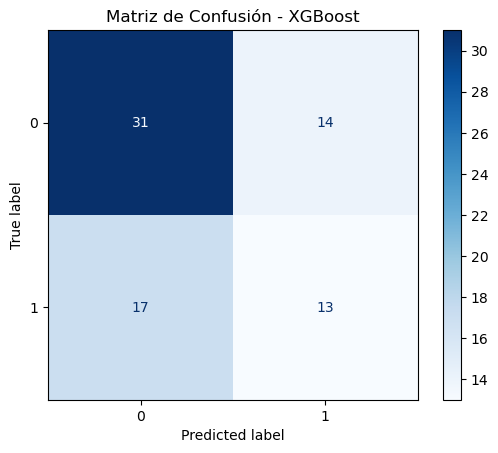

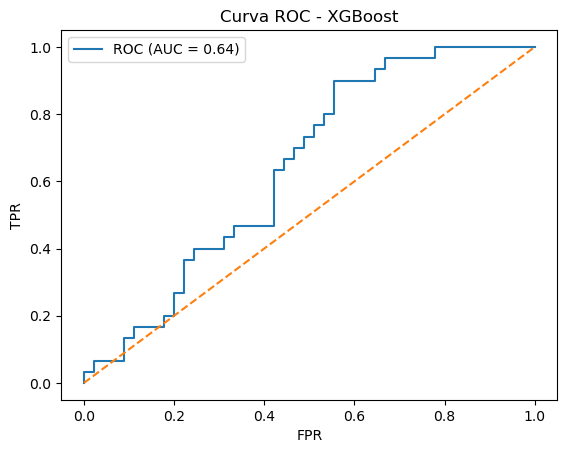

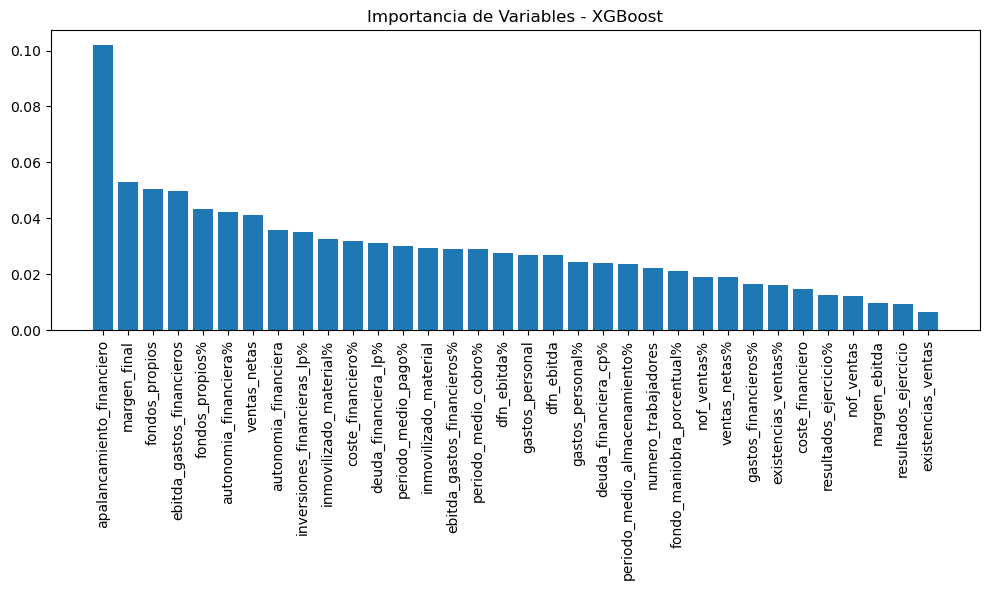

              precision    recall  f1-score   support

           0       0.65      0.69      0.67        45
           1       0.48      0.43      0.46        30

    accuracy                           0.59        75
   macro avg       0.56      0.56      0.56        75
weighted avg       0.58      0.59      0.58        75


 Entrenando GradientBoosting con Original


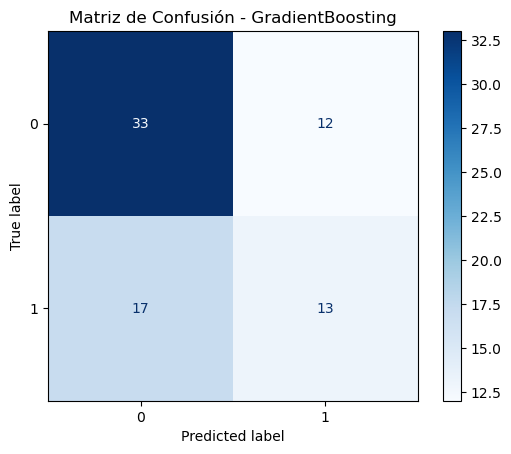

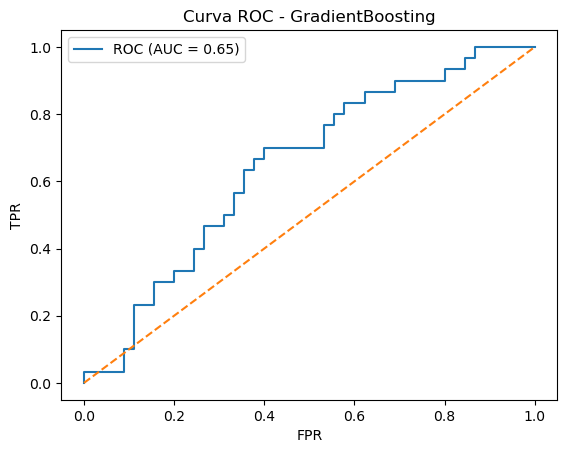

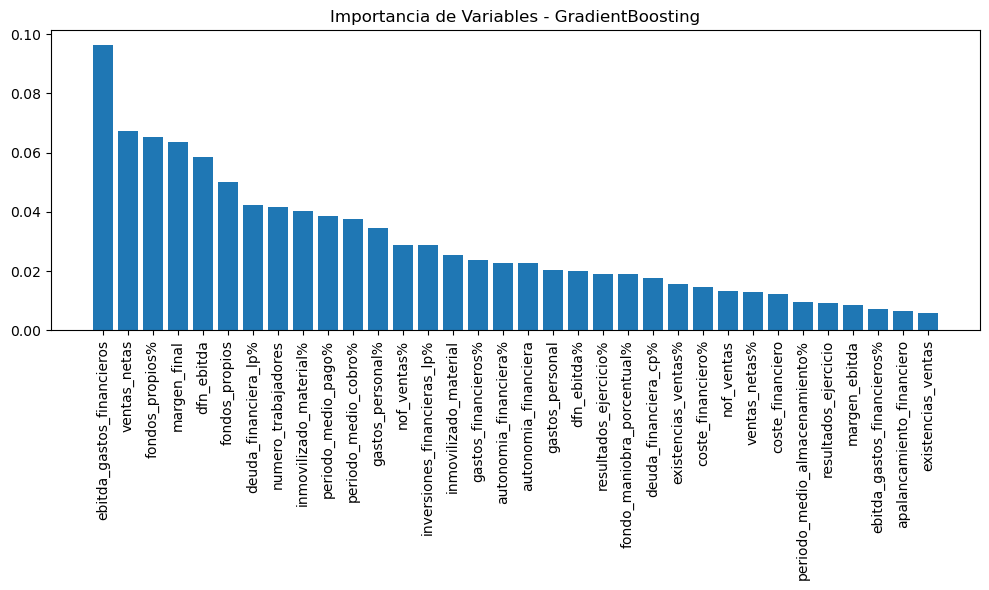

              precision    recall  f1-score   support

           0       0.66      0.73      0.69        45
           1       0.52      0.43      0.47        30

    accuracy                           0.61        75
   macro avg       0.59      0.58      0.58        75
weighted avg       0.60      0.61      0.61        75


 Entrenando KNN con Original


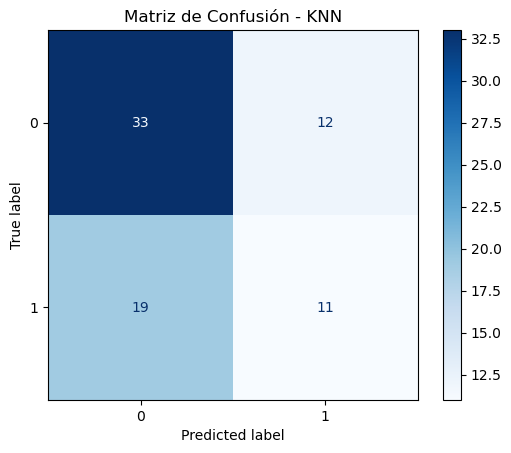

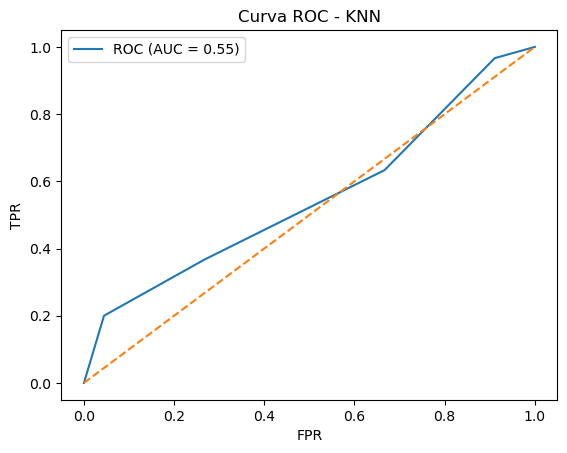

              precision    recall  f1-score   support

           0       0.63      0.73      0.68        45
           1       0.48      0.37      0.42        30

    accuracy                           0.59        75
   macro avg       0.56      0.55      0.55        75
weighted avg       0.57      0.59      0.57        75


 Entrenando SVC con Original


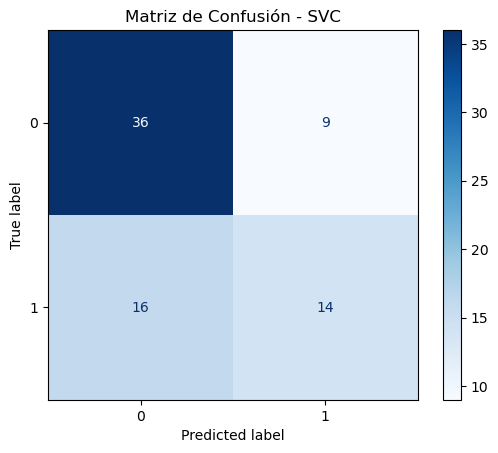

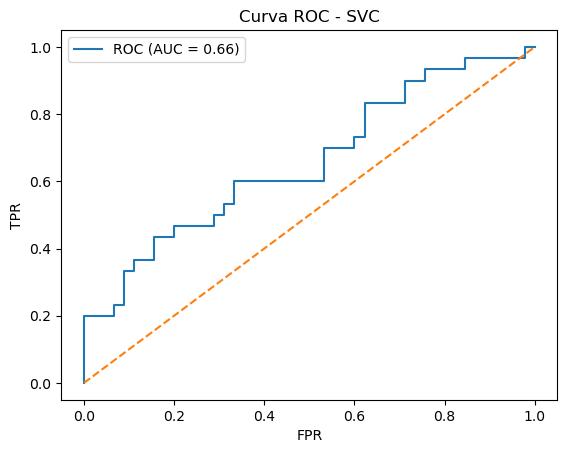

              precision    recall  f1-score   support

           0       0.69      0.80      0.74        45
           1       0.61      0.47      0.53        30

    accuracy                           0.67        75
   macro avg       0.65      0.63      0.64        75
weighted avg       0.66      0.67      0.66        75


 Entrenando NaiveBayes con Original


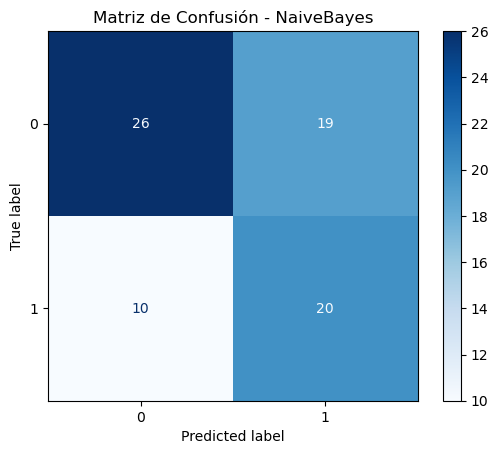

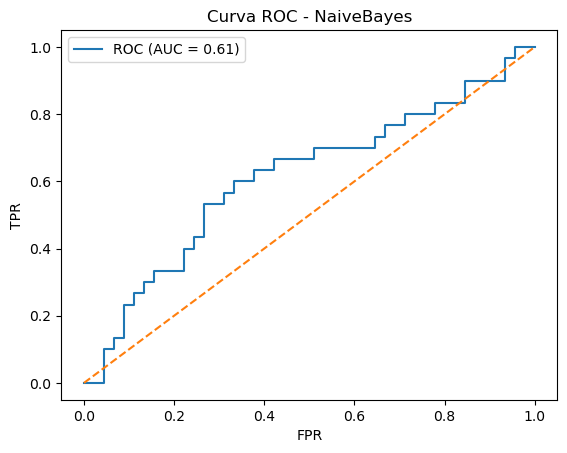

              precision    recall  f1-score   support

           0       0.72      0.58      0.64        45
           1       0.51      0.67      0.58        30

    accuracy                           0.61        75
   macro avg       0.62      0.62      0.61        75
weighted avg       0.64      0.61      0.62        75


 Entrenando MLP con Original


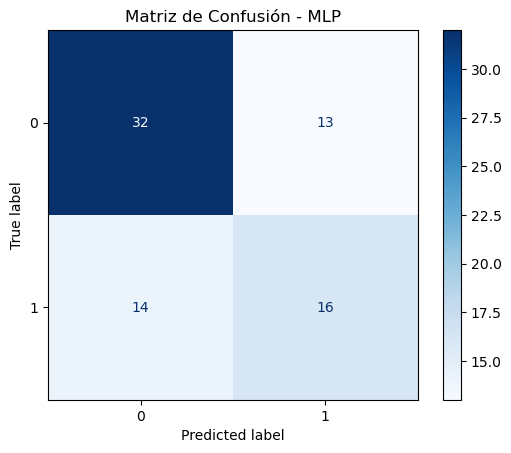

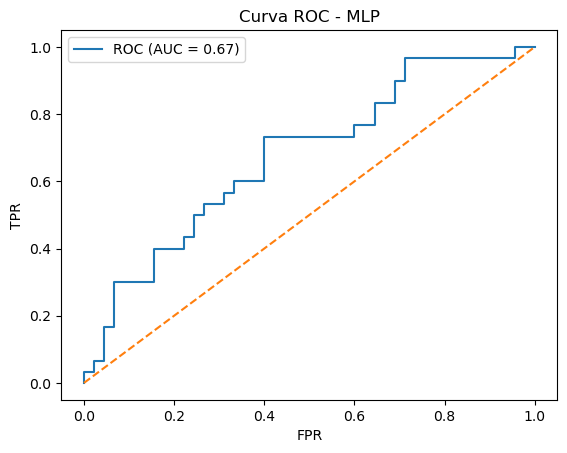

              precision    recall  f1-score   support

           0       0.70      0.71      0.70        45
           1       0.55      0.53      0.54        30

    accuracy                           0.64        75
   macro avg       0.62      0.62      0.62        75
weighted avg       0.64      0.64      0.64        75



dataset              modelo  accuracy  f1_score  precision    recall
6  Original          NaiveBayes  0.613333  0.579710   0.512821  0.666667
1  Original        RandomForest  0.680000  0.555556   0.625000  0.500000
7  Original                 MLP  0.640000  0.542373   0.551724  0.533333
5  Original                 SVC  0.666667  0.528302   0.608696  0.466667
0  Original  LogisticRegression  0.653333  0.518519   0.583333  0.466667
3  Original    GradientBoosting  0.613333  0.472727   0.520000  0.433333
2  Original             XGBoost  0.586667  0.456140   0.481481  0.433333
4  Original                 KNN  0.586667  0.415094   0.478261  0.366667


 Mejor modelo para Original: NaiveBayes (F1=0.58)
 Datos con SMOTE

 Entrenando LogisticRegression con SMOTE


/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


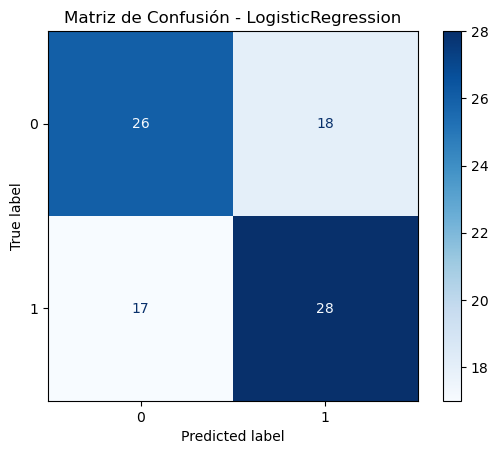

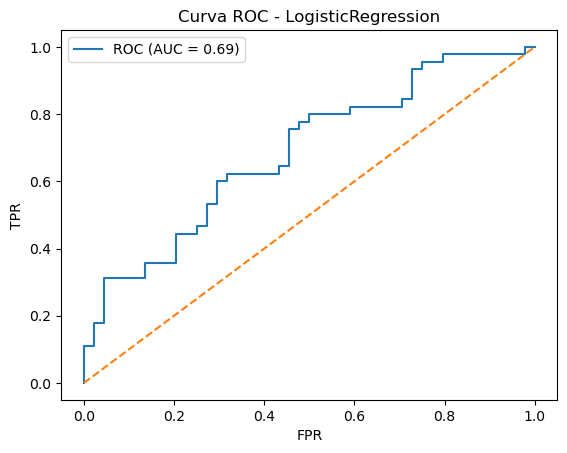

              precision    recall  f1-score   support

           0       0.60      0.59      0.60        44
           1       0.61      0.62      0.62        45

    accuracy                           0.61        89
   macro avg       0.61      0.61      0.61        89
weighted avg       0.61      0.61      0.61        89


 Entrenando RandomForest con SMOTE


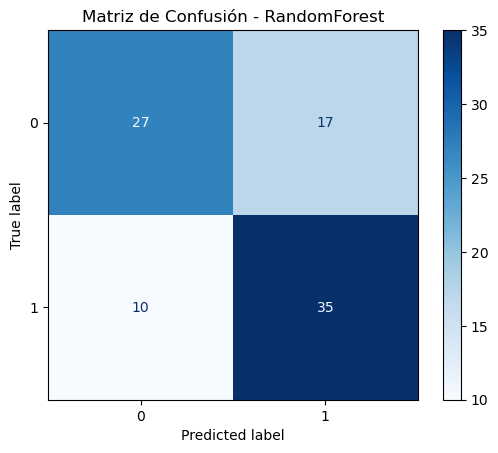

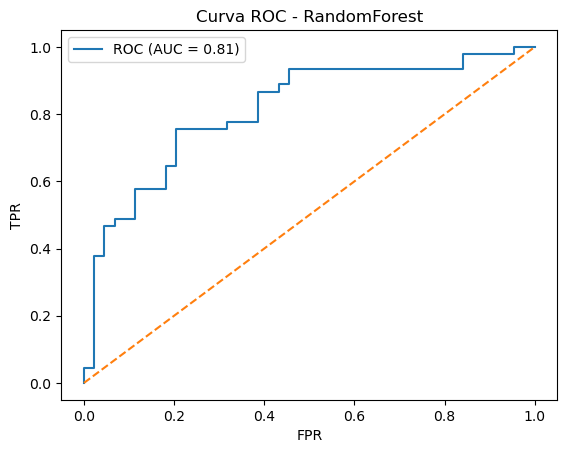

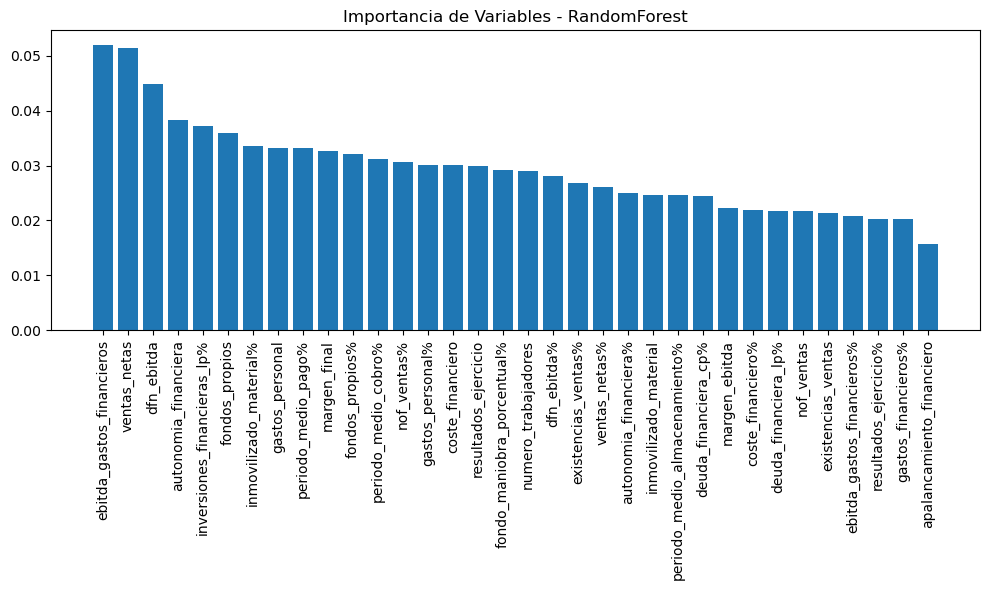

              precision    recall  f1-score   support

           0       0.73      0.61      0.67        44
           1       0.67      0.78      0.72        45

    accuracy                           0.70        89
   macro avg       0.70      0.70      0.69        89
weighted avg       0.70      0.70      0.69        89


 Entrenando XGBoost con SMOTE


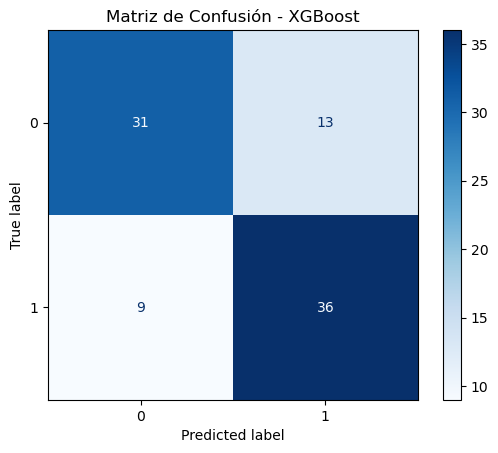

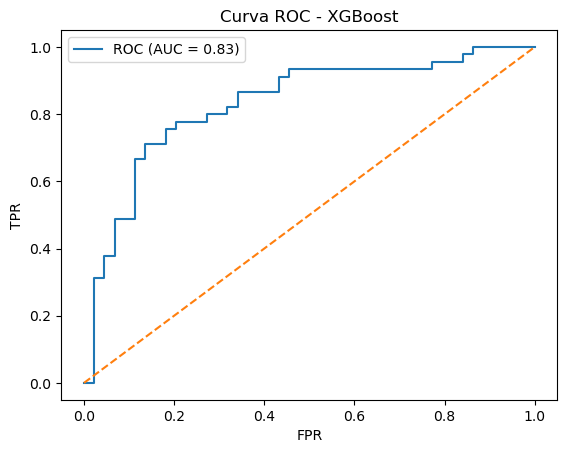

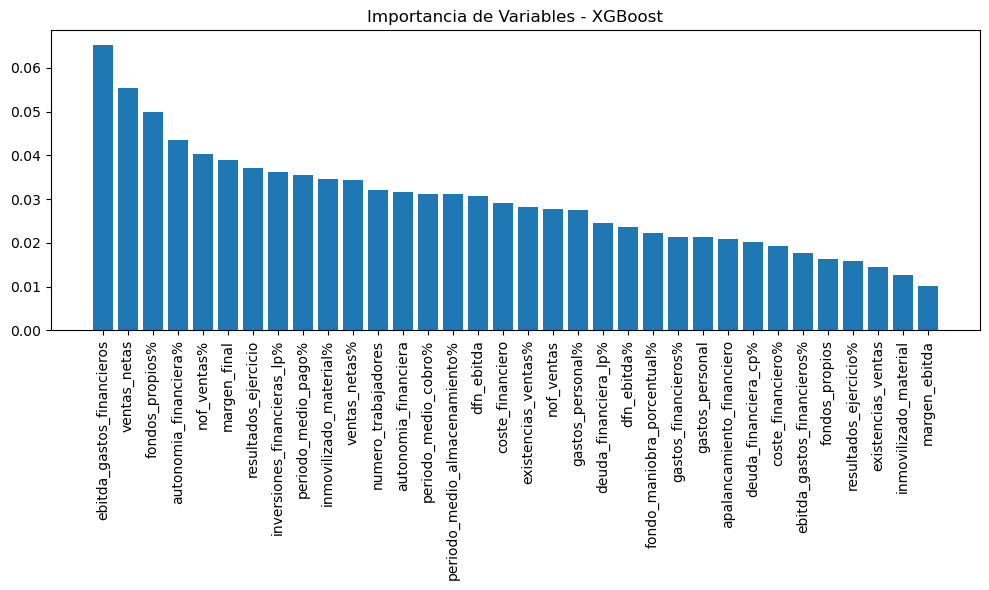

              precision    recall  f1-score   support

           0       0.78      0.70      0.74        44
           1       0.73      0.80      0.77        45

    accuracy                           0.75        89
   macro avg       0.75      0.75      0.75        89
weighted avg       0.75      0.75      0.75        89


 Entrenando GradientBoosting con SMOTE


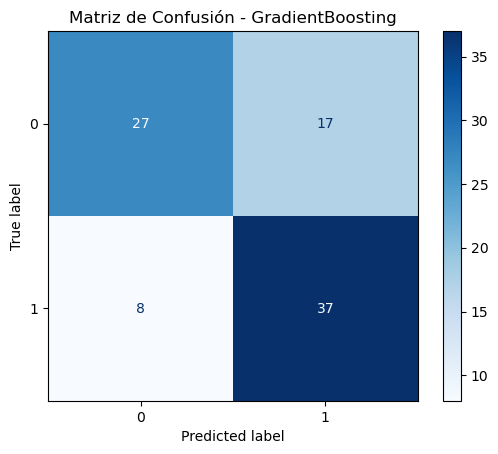

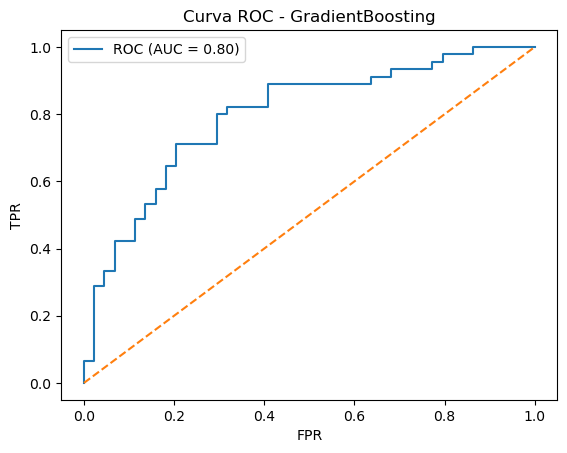

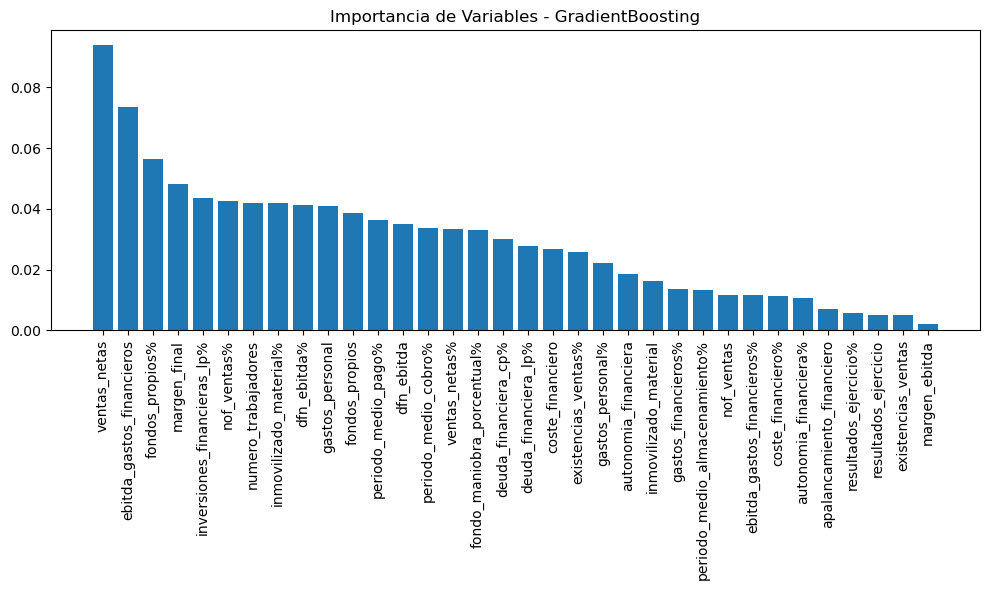

              precision    recall  f1-score   support

           0       0.77      0.61      0.68        44
           1       0.69      0.82      0.75        45

    accuracy                           0.72        89
   macro avg       0.73      0.72      0.72        89
weighted avg       0.73      0.72      0.72        89


 Entrenando KNN con SMOTE


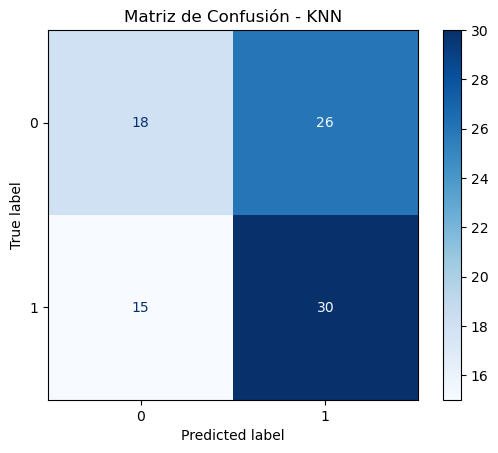

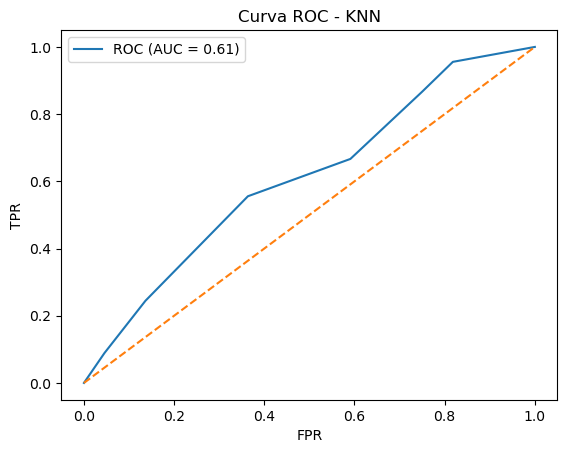

              precision    recall  f1-score   support

           0       0.55      0.41      0.47        44
           1       0.54      0.67      0.59        45

    accuracy                           0.54        89
   macro avg       0.54      0.54      0.53        89
weighted avg       0.54      0.54      0.53        89


 Entrenando SVC con SMOTE


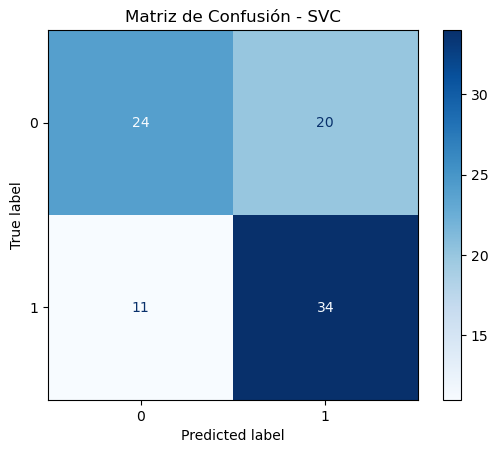

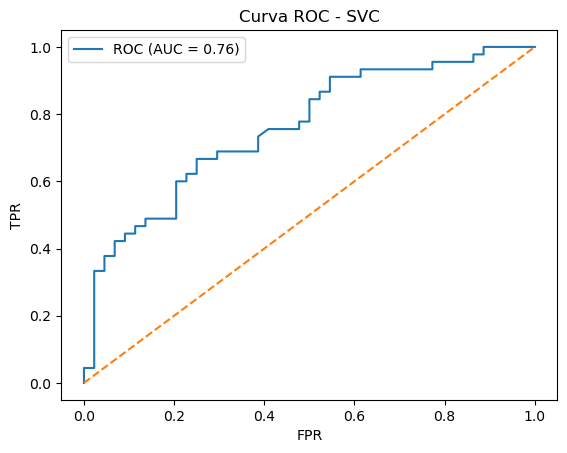

              precision    recall  f1-score   support

           0       0.69      0.55      0.61        44
           1       0.63      0.76      0.69        45

    accuracy                           0.65        89
   macro avg       0.66      0.65      0.65        89
weighted avg       0.66      0.65      0.65        89


 Entrenando NaiveBayes con SMOTE


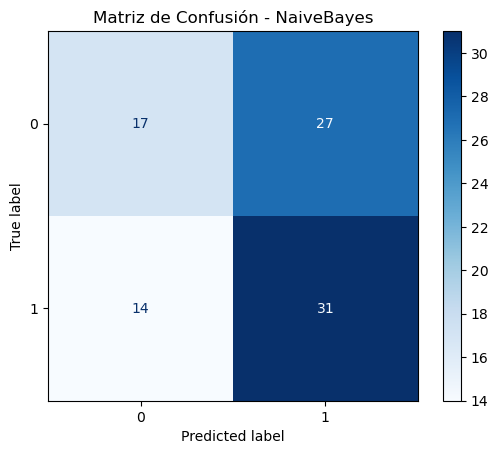

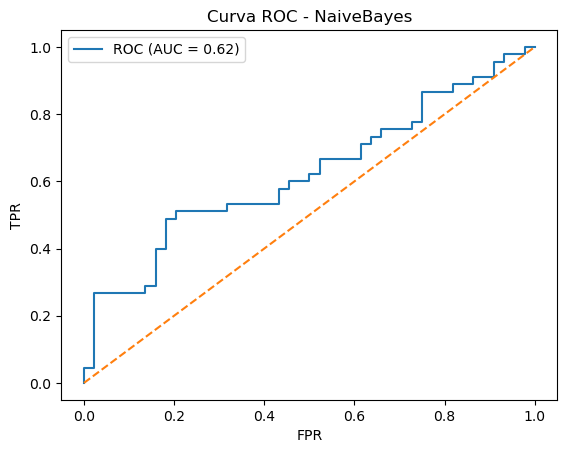

              precision    recall  f1-score   support

           0       0.55      0.39      0.45        44
           1       0.53      0.69      0.60        45

    accuracy                           0.54        89
   macro avg       0.54      0.54      0.53        89
weighted avg       0.54      0.54      0.53        89


 Entrenando MLP con SMOTE


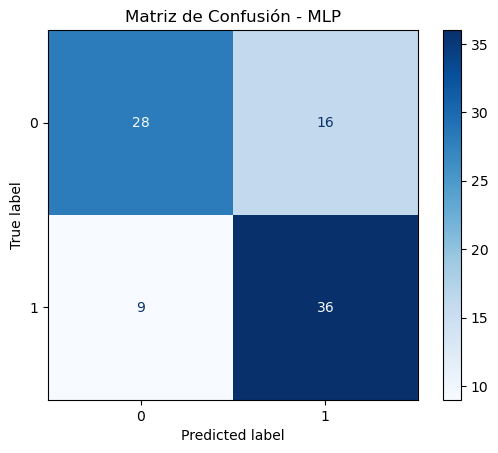

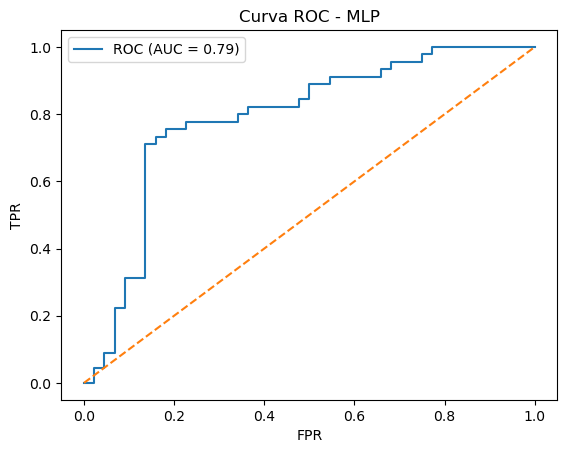

              precision    recall  f1-score   support

           0       0.76      0.64      0.69        44
           1       0.69      0.80      0.74        45

    accuracy                           0.72        89
   macro avg       0.72      0.72      0.72        89
weighted avg       0.72      0.72      0.72        89



dataset              modelo  accuracy  f1_score  precision    recall
2   SMOTE             XGBoost  0.752809  0.765957   0.734694  0.800000
3   SMOTE    GradientBoosting  0.719101  0.747475   0.685185  0.822222
7   SMOTE                 MLP  0.719101  0.742268   0.692308  0.800000
1   SMOTE        RandomForest  0.696629  0.721649   0.673077  0.777778
5   SMOTE                 SVC  0.651685  0.686869   0.629630  0.755556
0   SMOTE  LogisticRegression  0.606742  0.615385   0.608696  0.622222
6   SMOTE          NaiveBayes  0.539326  0.601942   0.534483  0.688889
4   SMOTE                 KNN  0.539326  0.594059   0.535714  0.666667


 Mejor modelo para SMOTE: XGBoost (F1=0.77)
 Datos con CTGAN
Distribución de clase sintética:
target_bin
0    160
1    140
Name: count, dtype: int64

 Entrenando LogisticRegression con CTGAN


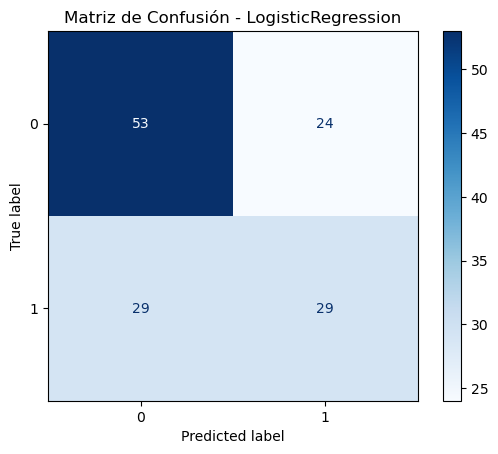

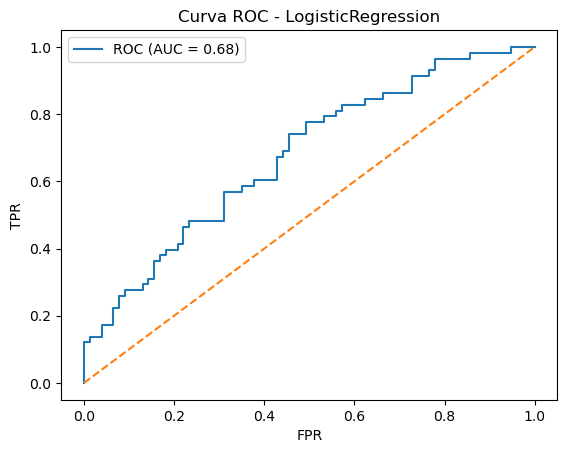

              precision    recall  f1-score   support

           0       0.65      0.69      0.67        77
           1       0.55      0.50      0.52        58

    accuracy                           0.61       135
   macro avg       0.60      0.59      0.59       135
weighted avg       0.60      0.61      0.60       135


 Entrenando RandomForest con CTGAN


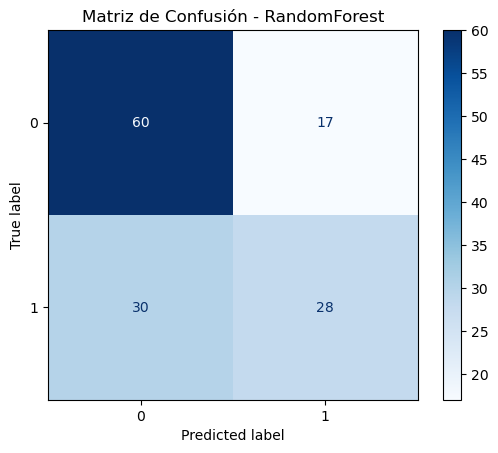

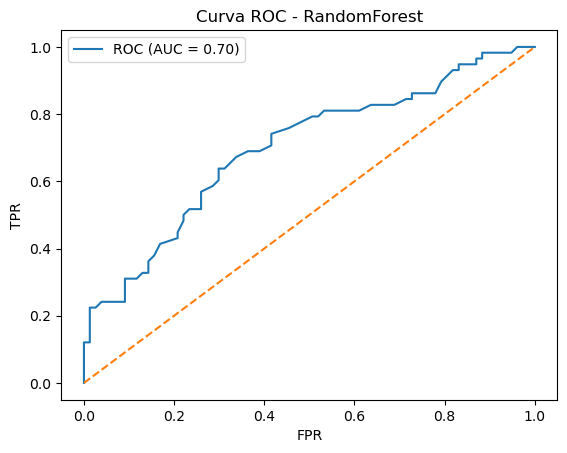

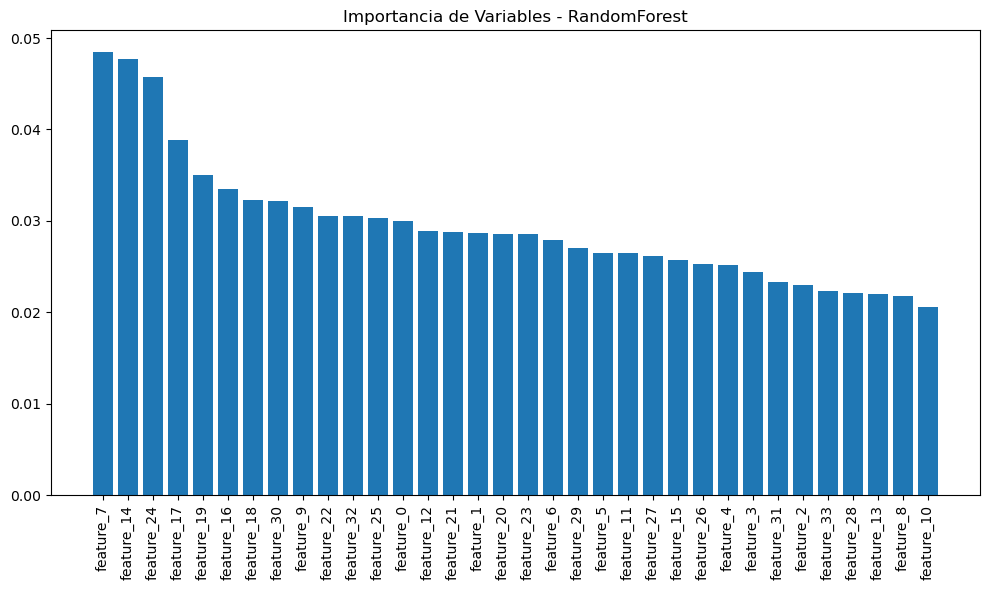

              precision    recall  f1-score   support

           0       0.67      0.78      0.72        77
           1       0.62      0.48      0.54        58

    accuracy                           0.65       135
   macro avg       0.64      0.63      0.63       135
weighted avg       0.65      0.65      0.64       135


 Entrenando XGBoost con CTGAN


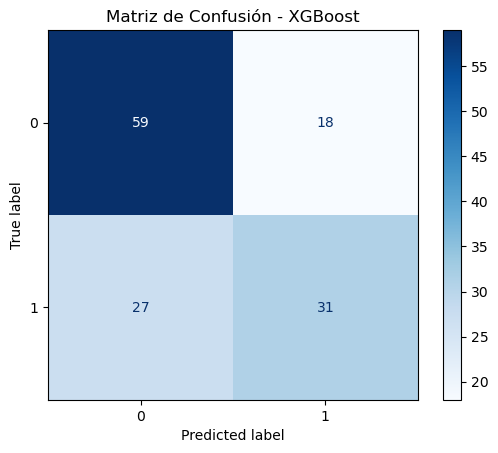

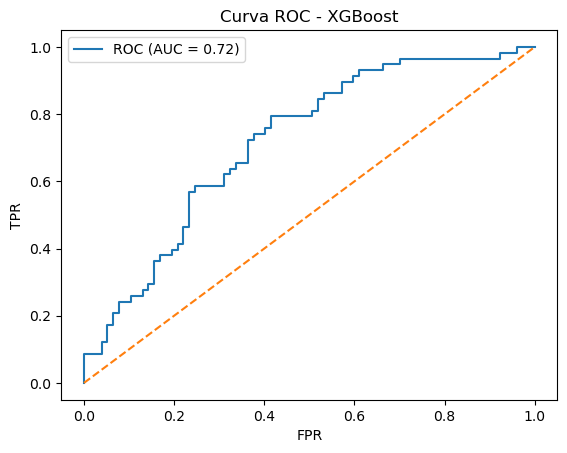

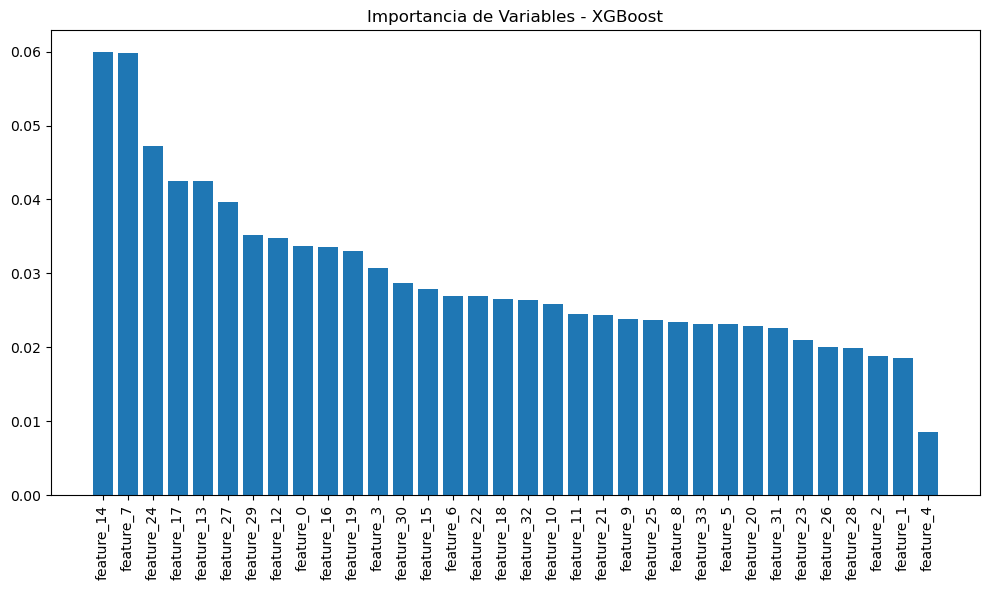

              precision    recall  f1-score   support

           0       0.69      0.77      0.72        77
           1       0.63      0.53      0.58        58

    accuracy                           0.67       135
   macro avg       0.66      0.65      0.65       135
weighted avg       0.66      0.67      0.66       135


 Entrenando GradientBoosting con CTGAN


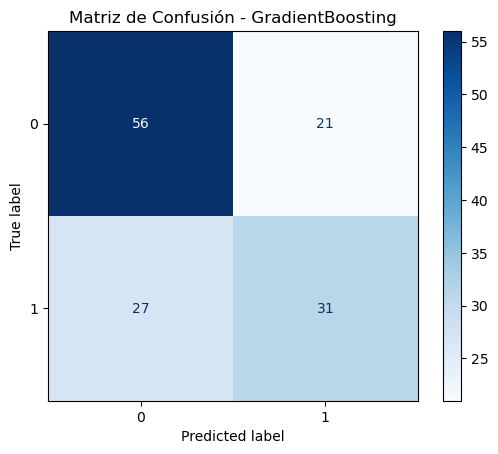

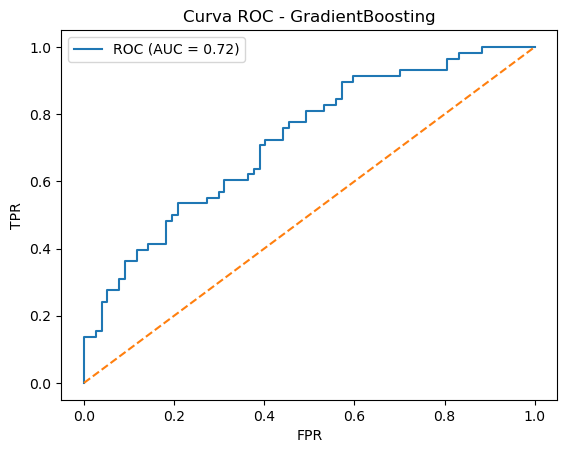

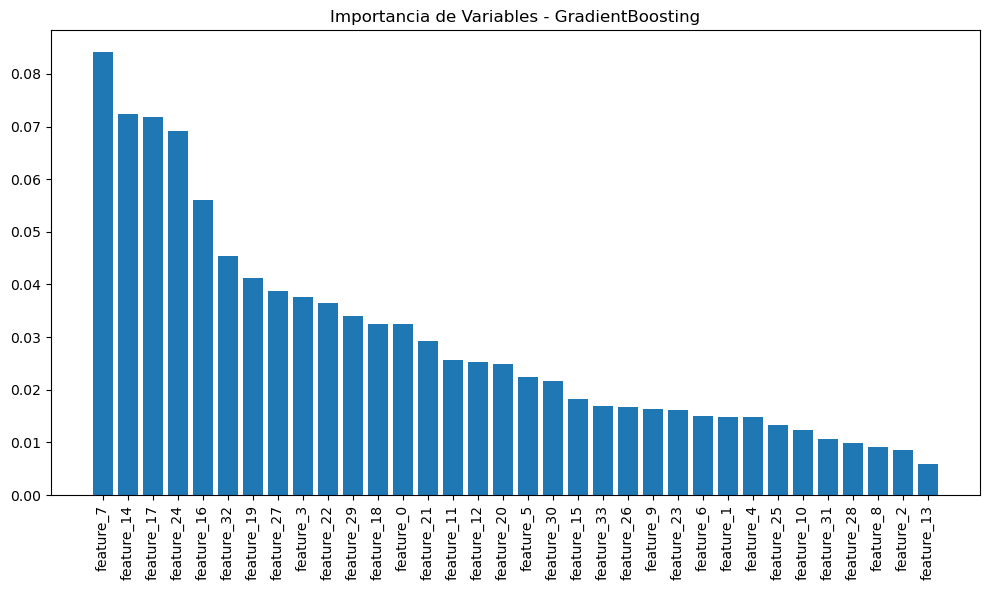

              precision    recall  f1-score   support

           0       0.67      0.73      0.70        77
           1       0.60      0.53      0.56        58

    accuracy                           0.64       135
   macro avg       0.64      0.63      0.63       135
weighted avg       0.64      0.64      0.64       135


 Entrenando KNN con CTGAN


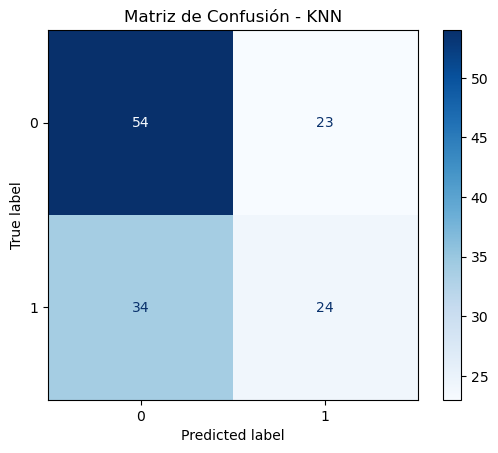

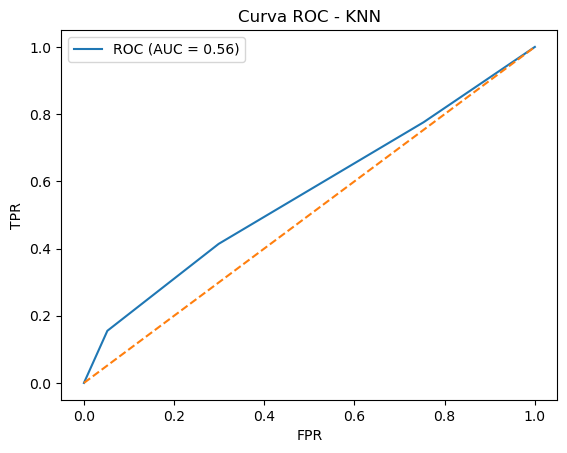

              precision    recall  f1-score   support

           0       0.61      0.70      0.65        77
           1       0.51      0.41      0.46        58

    accuracy                           0.58       135
   macro avg       0.56      0.56      0.56       135
weighted avg       0.57      0.58      0.57       135


 Entrenando SVC con CTGAN


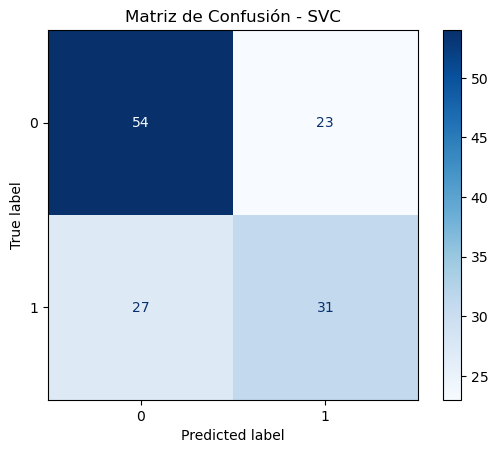

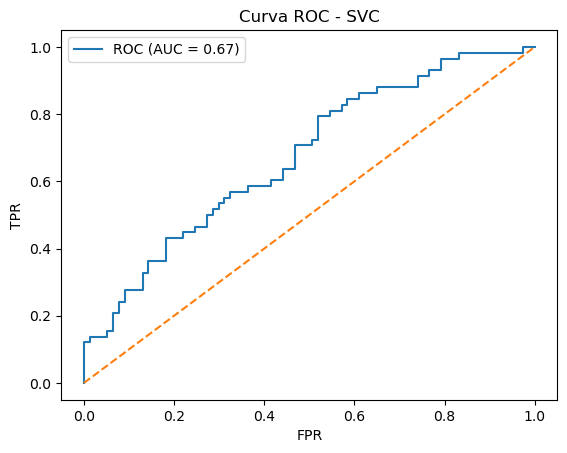

              precision    recall  f1-score   support

           0       0.67      0.70      0.68        77
           1       0.57      0.53      0.55        58

    accuracy                           0.63       135
   macro avg       0.62      0.62      0.62       135
weighted avg       0.63      0.63      0.63       135


 Entrenando NaiveBayes con CTGAN


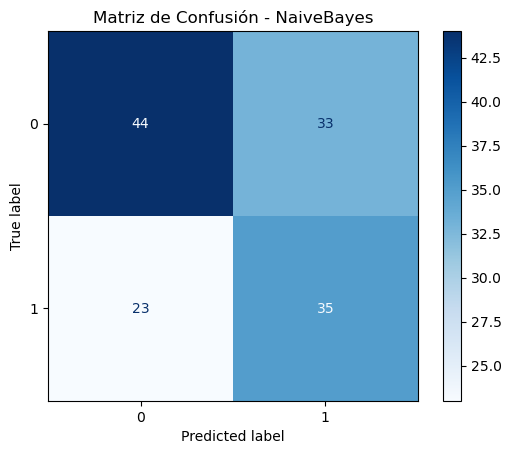

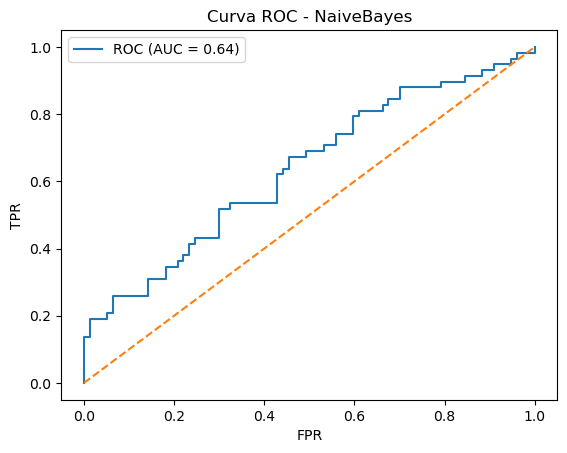

              precision    recall  f1-score   support

           0       0.66      0.57      0.61        77
           1       0.51      0.60      0.56        58

    accuracy                           0.59       135
   macro avg       0.59      0.59      0.58       135
weighted avg       0.60      0.59      0.59       135


 Entrenando MLP con CTGAN


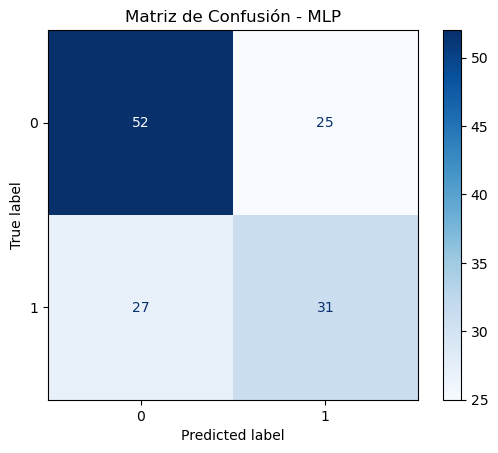

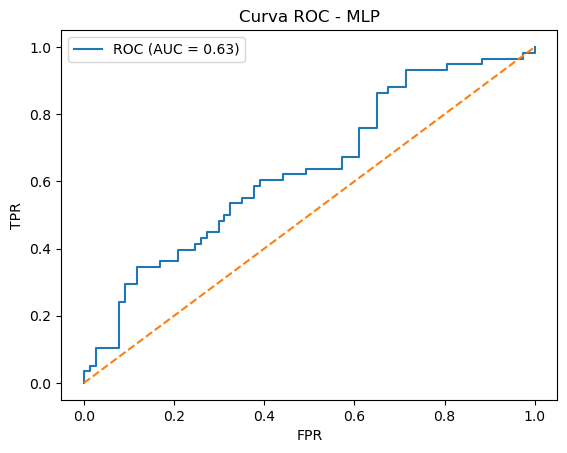

              precision    recall  f1-score   support

           0       0.66      0.68      0.67        77
           1       0.55      0.53      0.54        58

    accuracy                           0.61       135
   macro avg       0.61      0.60      0.61       135
weighted avg       0.61      0.61      0.61       135



dataset              modelo  accuracy  f1_score  precision    recall
2   CTGAN             XGBoost  0.666667  0.579439   0.632653  0.534483
3   CTGAN    GradientBoosting  0.644444  0.563636   0.596154  0.534483
6   CTGAN          NaiveBayes  0.585185  0.555556   0.514706  0.603448
5   CTGAN                 SVC  0.629630  0.553571   0.574074  0.534483
7   CTGAN                 MLP  0.614815  0.543860   0.553571  0.534483
1   CTGAN        RandomForest  0.651852  0.543689   0.622222  0.482759
0   CTGAN  LogisticRegression  0.607407  0.522523   0.547170  0.500000
4   CTGAN                 KNN  0.577778  0.457143   0.510638  0.413793


 Mejor modelo para CTGAN: XGBoost (F1=0.58)
 Datos con CTGAN + SMOTE

 Entrenando LogisticRegression con CTGAN+SMOTE


/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


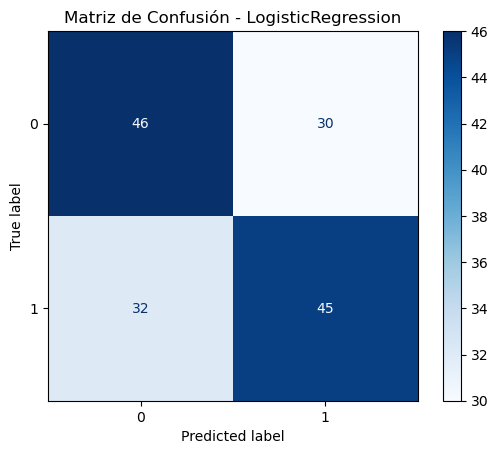

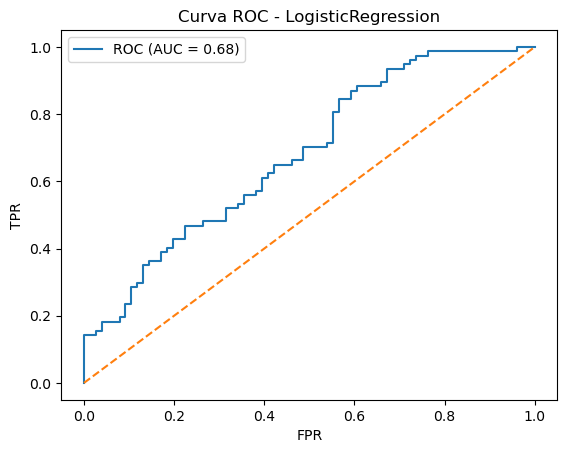

              precision    recall  f1-score   support

           0       0.59      0.61      0.60        76
           1       0.60      0.58      0.59        77

    accuracy                           0.59       153
   macro avg       0.59      0.59      0.59       153
weighted avg       0.59      0.59      0.59       153


 Entrenando RandomForest con CTGAN+SMOTE


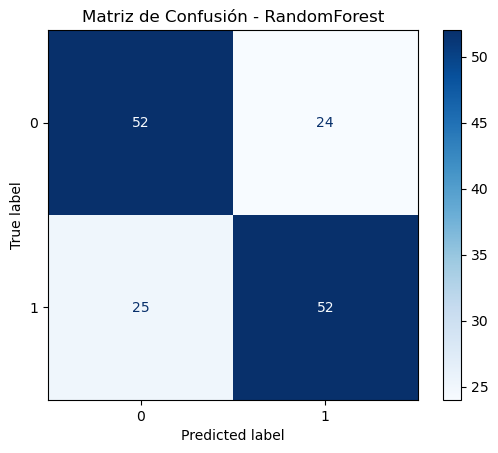

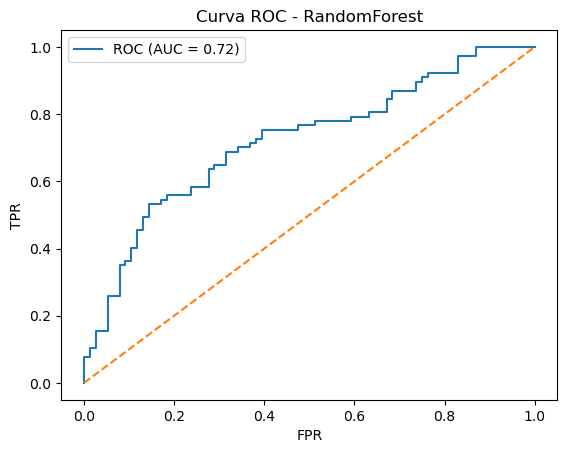

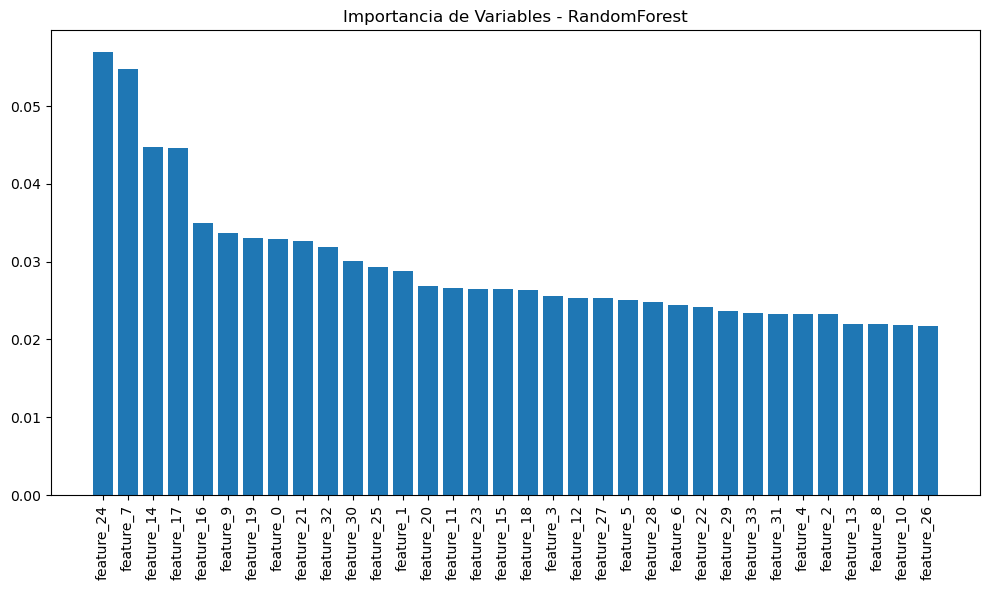

              precision    recall  f1-score   support

           0       0.68      0.68      0.68        76
           1       0.68      0.68      0.68        77

    accuracy                           0.68       153
   macro avg       0.68      0.68      0.68       153
weighted avg       0.68      0.68      0.68       153


 Entrenando XGBoost con CTGAN+SMOTE


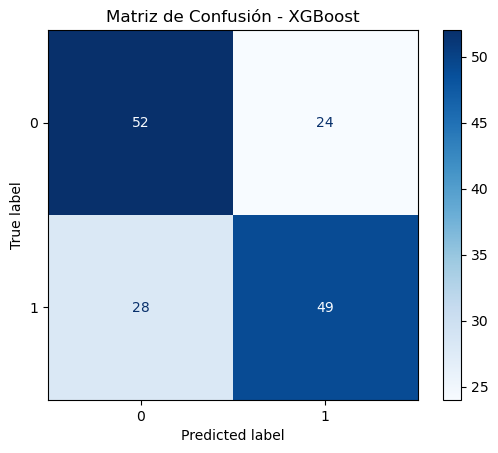

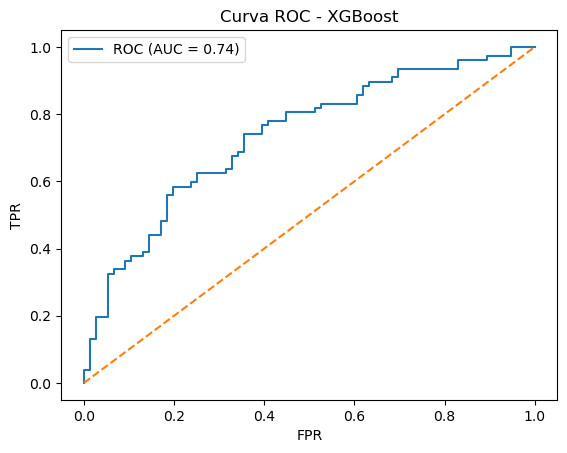

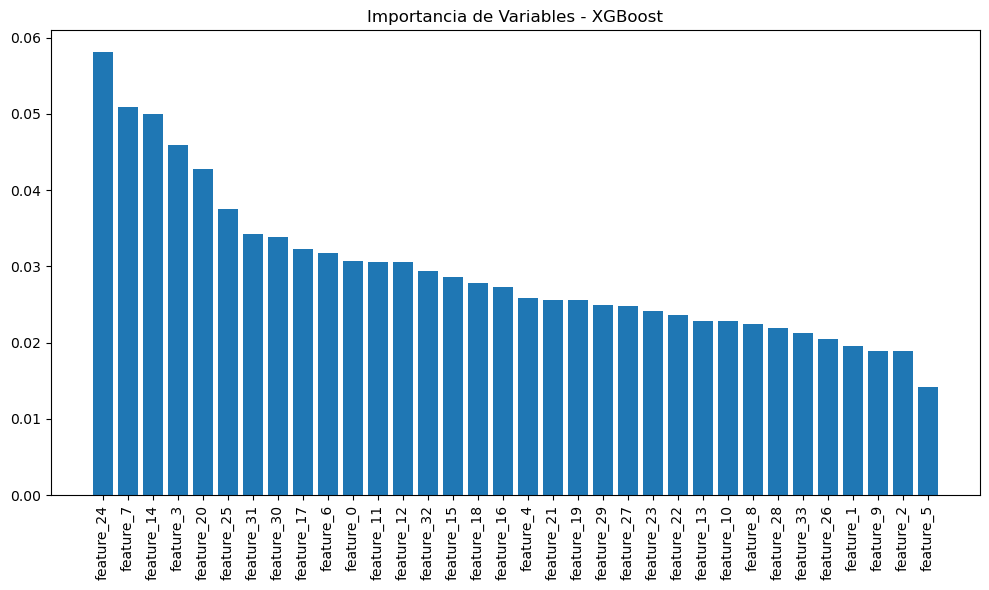

              precision    recall  f1-score   support

           0       0.65      0.68      0.67        76
           1       0.67      0.64      0.65        77

    accuracy                           0.66       153
   macro avg       0.66      0.66      0.66       153
weighted avg       0.66      0.66      0.66       153


 Entrenando GradientBoosting con CTGAN+SMOTE


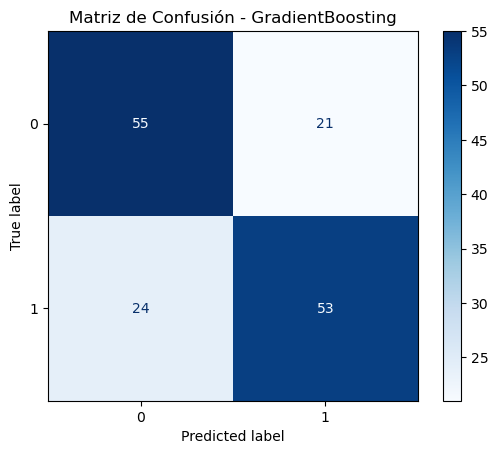

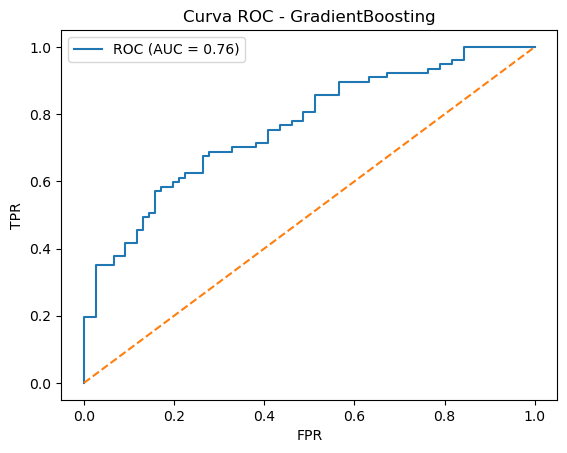

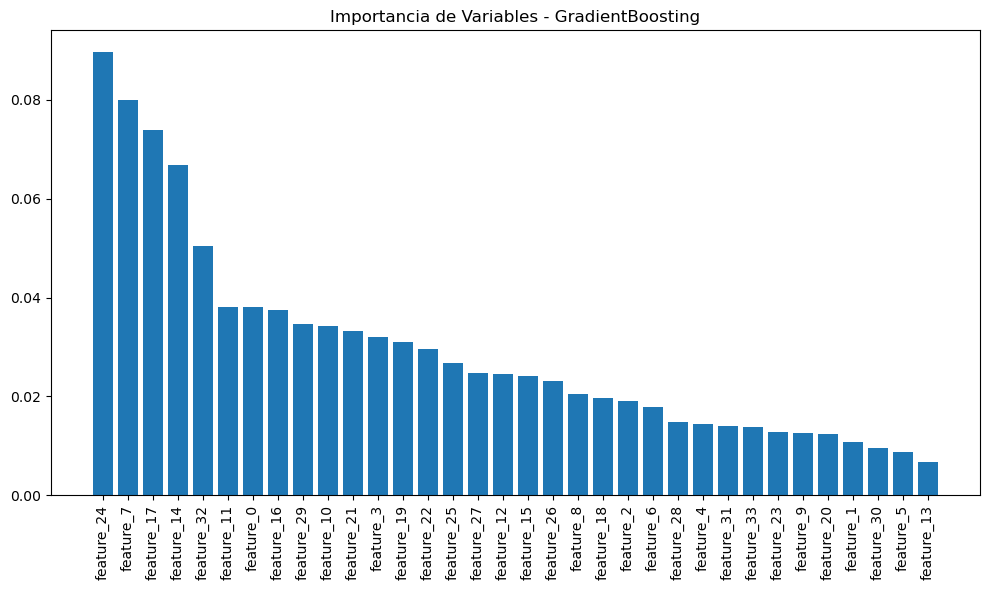

              precision    recall  f1-score   support

           0       0.70      0.72      0.71        76
           1       0.72      0.69      0.70        77

    accuracy                           0.71       153
   macro avg       0.71      0.71      0.71       153
weighted avg       0.71      0.71      0.71       153


 Entrenando KNN con CTGAN+SMOTE


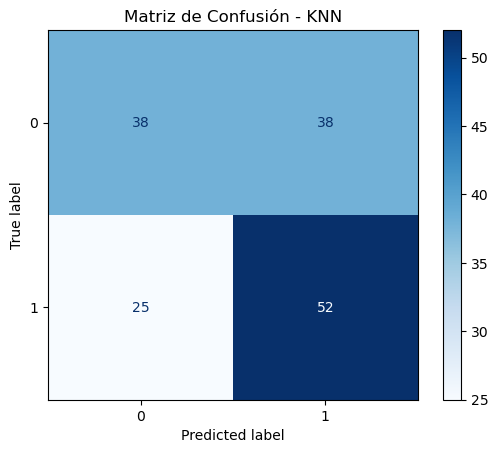

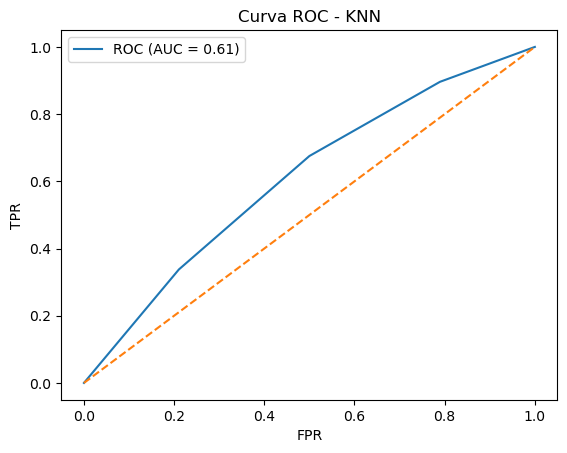

              precision    recall  f1-score   support

           0       0.60      0.50      0.55        76
           1       0.58      0.68      0.62        77

    accuracy                           0.59       153
   macro avg       0.59      0.59      0.58       153
weighted avg       0.59      0.59      0.59       153


 Entrenando SVC con CTGAN+SMOTE


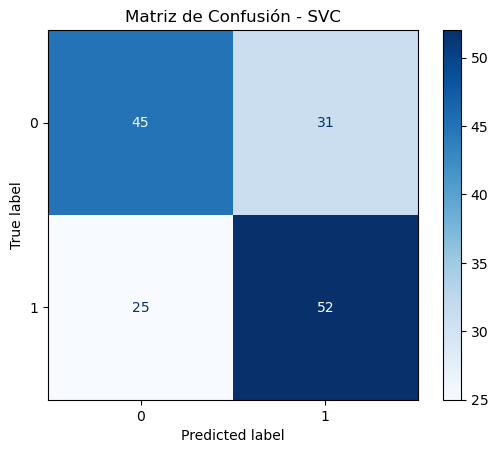

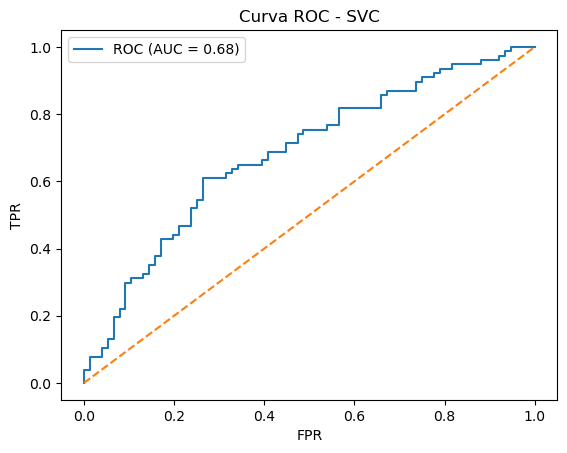

              precision    recall  f1-score   support

           0       0.64      0.59      0.62        76
           1       0.63      0.68      0.65        77

    accuracy                           0.63       153
   macro avg       0.63      0.63      0.63       153
weighted avg       0.63      0.63      0.63       153


 Entrenando NaiveBayes con CTGAN+SMOTE


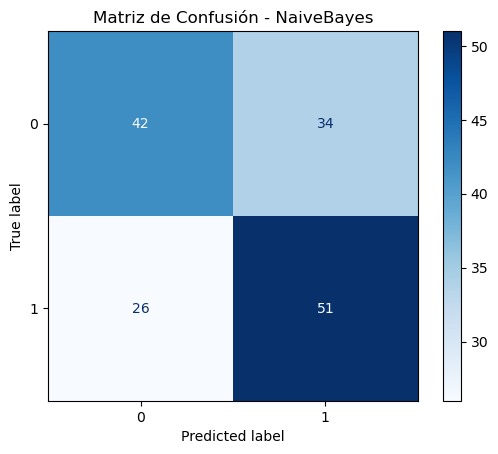

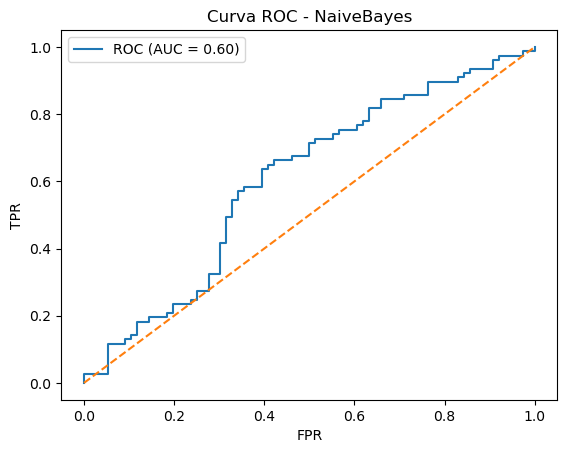

              precision    recall  f1-score   support

           0       0.62      0.55      0.58        76
           1       0.60      0.66      0.63        77

    accuracy                           0.61       153
   macro avg       0.61      0.61      0.61       153
weighted avg       0.61      0.61      0.61       153


 Entrenando MLP con CTGAN+SMOTE


/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/myen

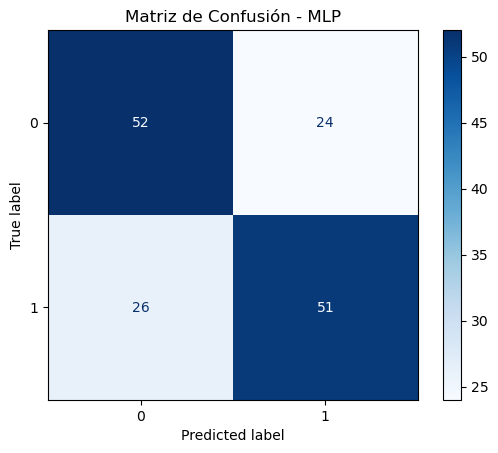

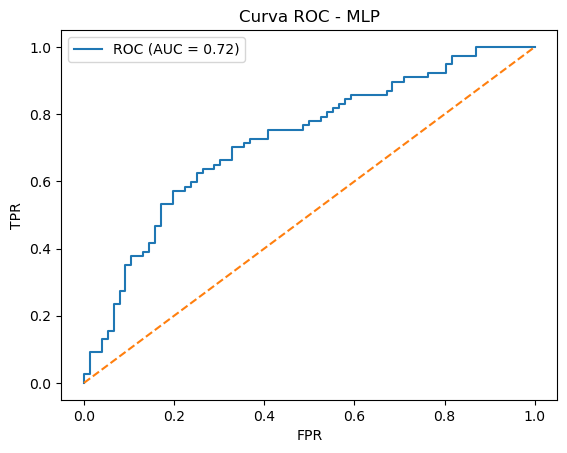

              precision    recall  f1-score   support

           0       0.67      0.68      0.68        76
           1       0.68      0.66      0.67        77

    accuracy                           0.67       153
   macro avg       0.67      0.67      0.67       153
weighted avg       0.67      0.67      0.67       153



dataset              modelo  accuracy  f1_score  precision    recall
3  CTGAN+SMOTE    GradientBoosting  0.705882  0.701987   0.716216  0.688312
1  CTGAN+SMOTE        RandomForest  0.679739  0.679739   0.684211  0.675325
7  CTGAN+SMOTE                 MLP  0.673203  0.671053   0.680000  0.662338
2  CTGAN+SMOTE             XGBoost  0.660131  0.653333   0.671233  0.636364
5  CTGAN+SMOTE                 SVC  0.633987  0.650000   0.626506  0.675325
6  CTGAN+SMOTE          NaiveBayes  0.607843  0.629630   0.600000  0.662338
4  CTGAN+SMOTE                 KNN  0.588235  0.622754   0.577778  0.675325
0  CTGAN+SMOTE  LogisticRegression  0.594771  0.592105   0.600000  0.584416


 Mejor modelo para CTGAN+SMOTE: GradientBoosting (F1=0.70)
 Datos con SMOTE + CTGAN
Distribución de clase sintética:
target_bin
1    152
0    148
Name: count, dtype: int64

 Entrenando LogisticRegression con SMOTE+CTGAN


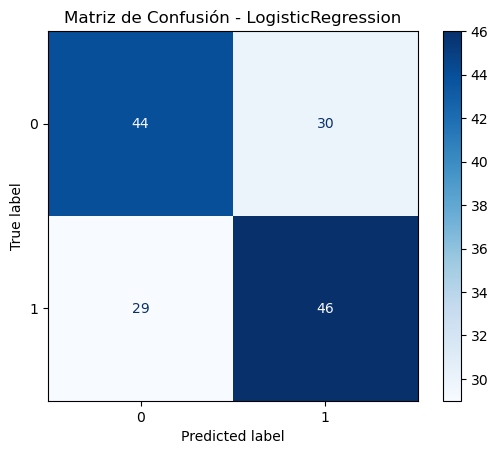

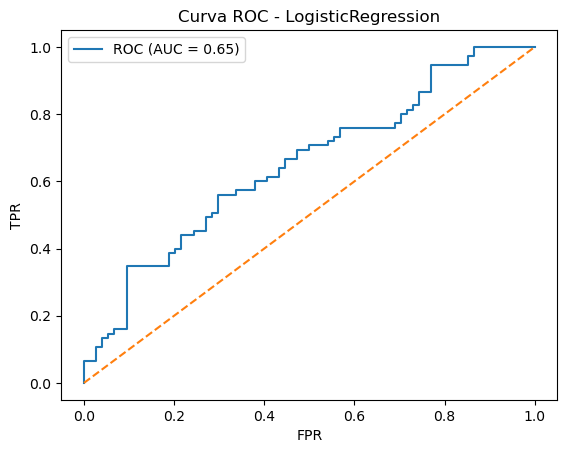

              precision    recall  f1-score   support

           0       0.60      0.59      0.60        74
           1       0.61      0.61      0.61        75

    accuracy                           0.60       149
   macro avg       0.60      0.60      0.60       149
weighted avg       0.60      0.60      0.60       149


 Entrenando RandomForest con SMOTE+CTGAN


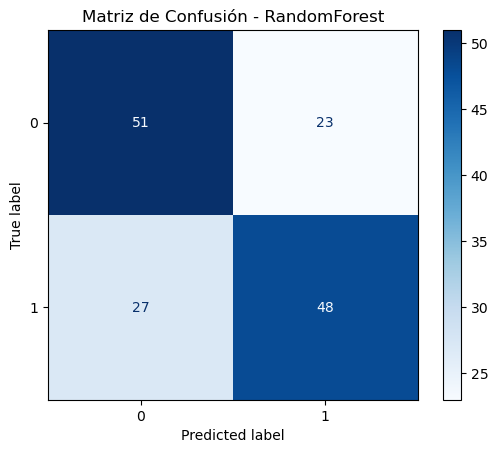

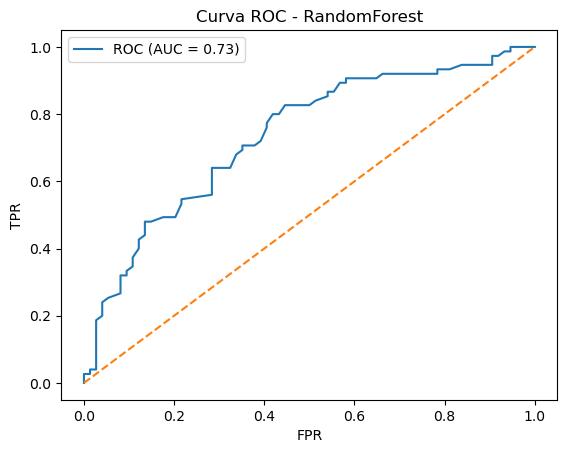

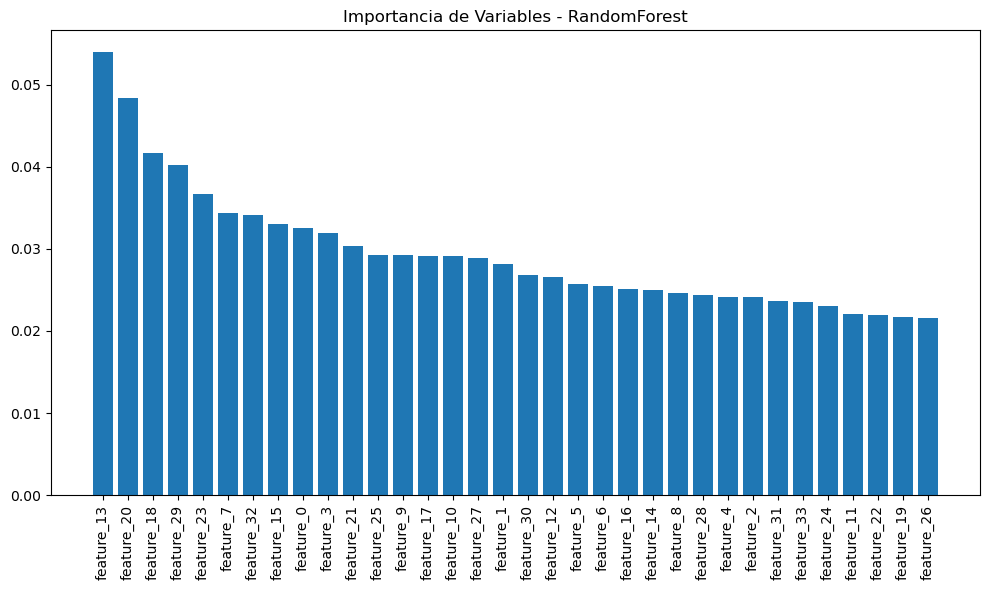

              precision    recall  f1-score   support

           0       0.65      0.69      0.67        74
           1       0.68      0.64      0.66        75

    accuracy                           0.66       149
   macro avg       0.66      0.66      0.66       149
weighted avg       0.67      0.66      0.66       149


 Entrenando XGBoost con SMOTE+CTGAN


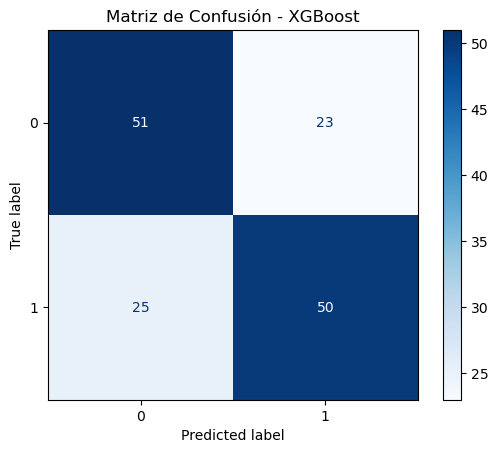

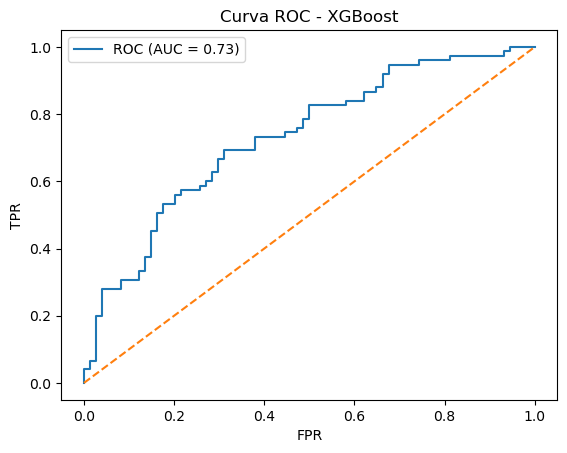

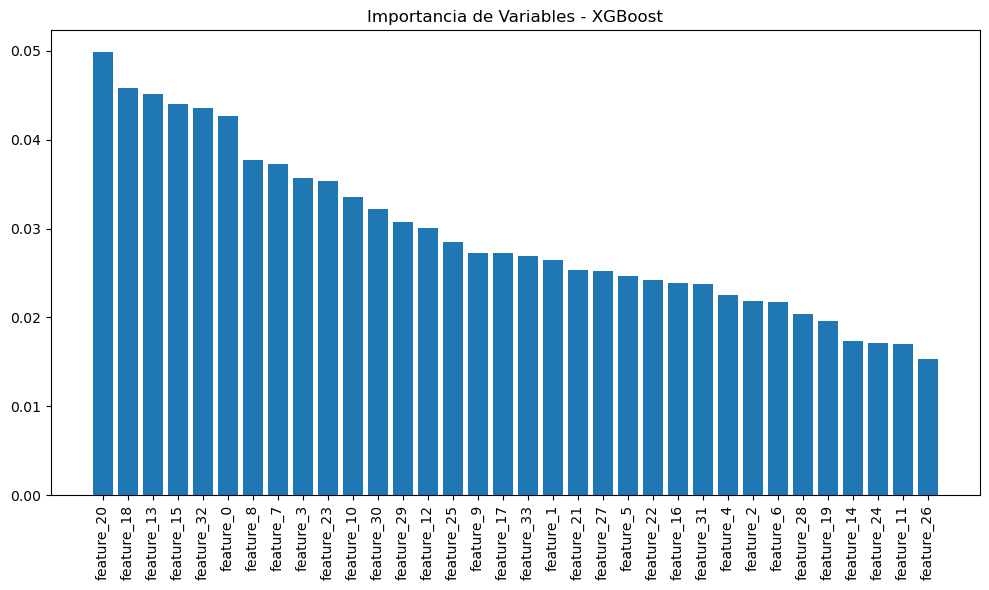

              precision    recall  f1-score   support

           0       0.67      0.69      0.68        74
           1       0.68      0.67      0.68        75

    accuracy                           0.68       149
   macro avg       0.68      0.68      0.68       149
weighted avg       0.68      0.68      0.68       149


 Entrenando GradientBoosting con SMOTE+CTGAN


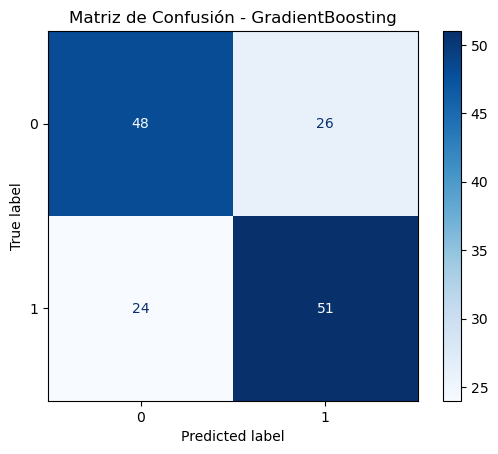

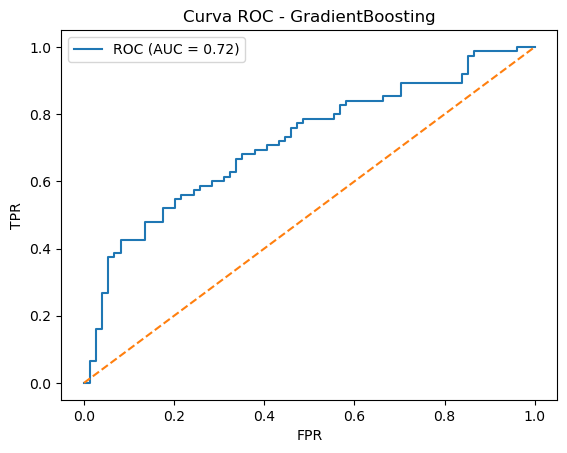

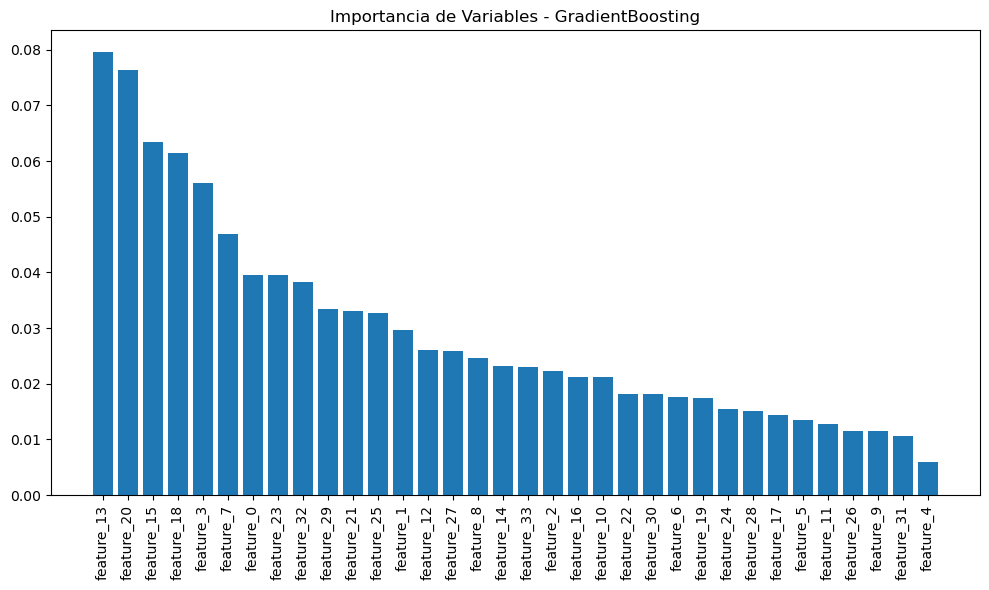

              precision    recall  f1-score   support

           0       0.67      0.65      0.66        74
           1       0.66      0.68      0.67        75

    accuracy                           0.66       149
   macro avg       0.66      0.66      0.66       149
weighted avg       0.66      0.66      0.66       149


 Entrenando KNN con SMOTE+CTGAN


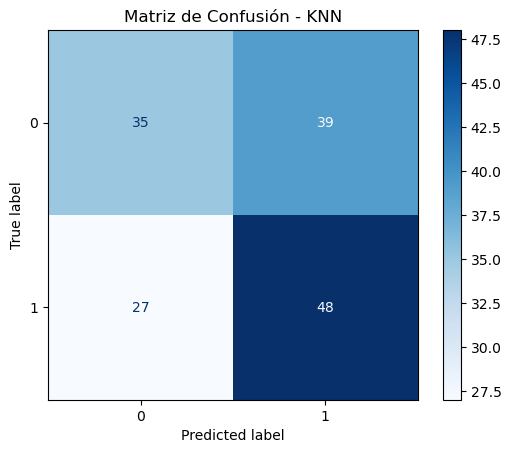

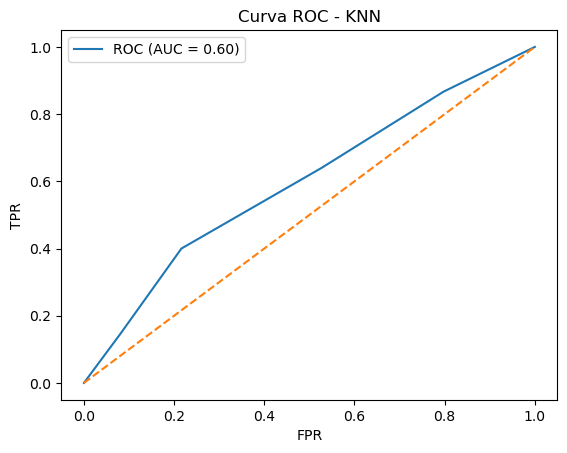

              precision    recall  f1-score   support

           0       0.56      0.47      0.51        74
           1       0.55      0.64      0.59        75

    accuracy                           0.56       149
   macro avg       0.56      0.56      0.55       149
weighted avg       0.56      0.56      0.55       149


 Entrenando SVC con SMOTE+CTGAN


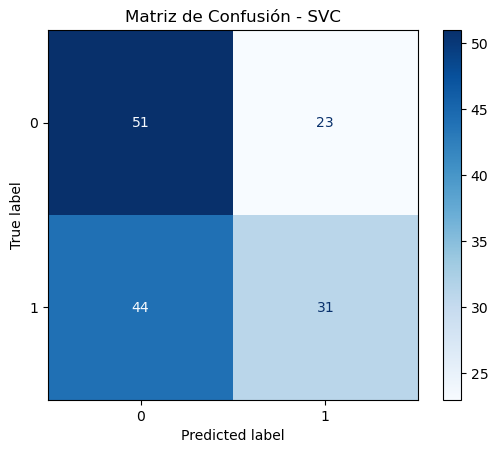

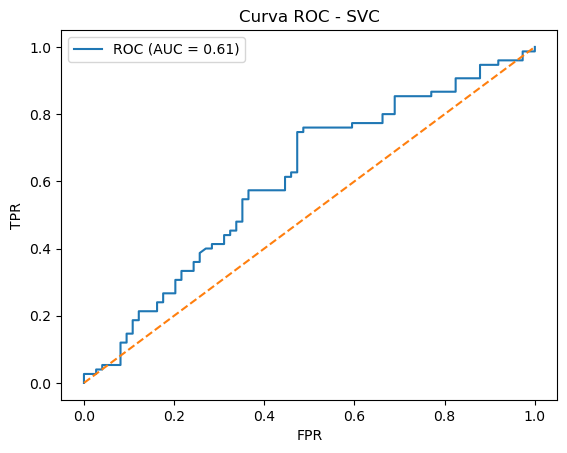

              precision    recall  f1-score   support

           0       0.54      0.69      0.60        74
           1       0.57      0.41      0.48        75

    accuracy                           0.55       149
   macro avg       0.56      0.55      0.54       149
weighted avg       0.56      0.55      0.54       149


 Entrenando NaiveBayes con SMOTE+CTGAN


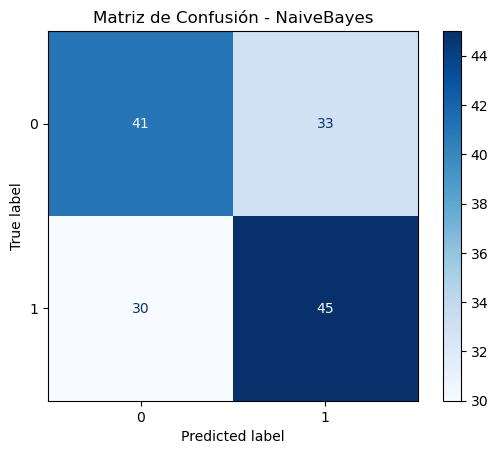

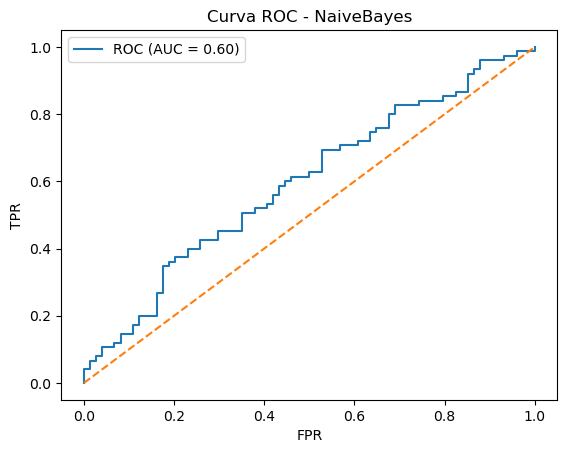

              precision    recall  f1-score   support

           0       0.58      0.55      0.57        74
           1       0.58      0.60      0.59        75

    accuracy                           0.58       149
   macro avg       0.58      0.58      0.58       149
weighted avg       0.58      0.58      0.58       149


 Entrenando MLP con SMOTE+CTGAN


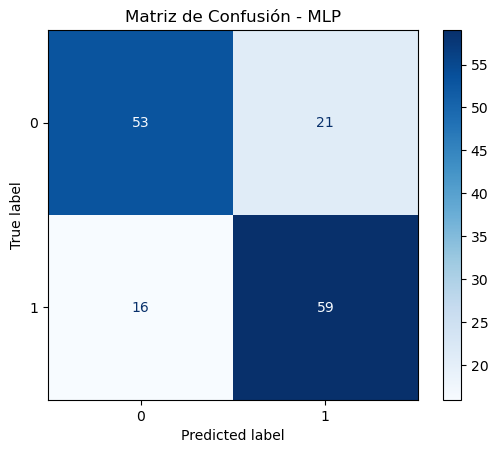

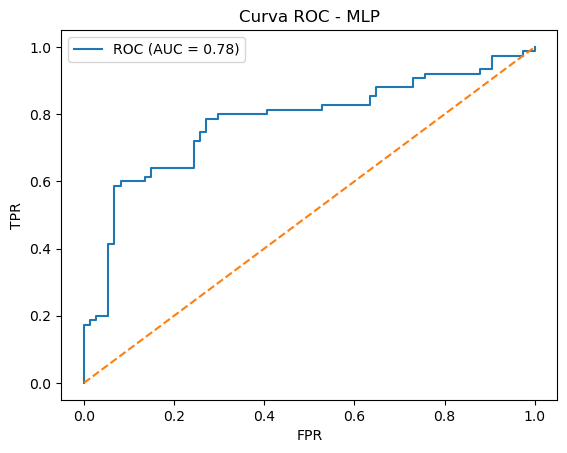

              precision    recall  f1-score   support

           0       0.77      0.72      0.74        74
           1       0.74      0.79      0.76        75

    accuracy                           0.75       149
   macro avg       0.75      0.75      0.75       149
weighted avg       0.75      0.75      0.75       149



dataset              modelo  accuracy  f1_score  precision    recall
7  SMOTE+CTGAN                 MLP  0.751678  0.761290   0.737500  0.786667
2  SMOTE+CTGAN             XGBoost  0.677852  0.675676   0.684932  0.666667
3  SMOTE+CTGAN    GradientBoosting  0.664430  0.671053   0.662338  0.680000
1  SMOTE+CTGAN        RandomForest  0.664430  0.657534   0.676056  0.640000
0  SMOTE+CTGAN  LogisticRegression  0.604027  0.609272   0.605263  0.613333
4  SMOTE+CTGAN                 KNN  0.557047  0.592593   0.551724  0.640000
6  SMOTE+CTGAN          NaiveBayes  0.577181  0.588235   0.576923  0.600000
5  SMOTE+CTGAN                 SVC  0.550336  0.480620   0.574074  0.413333


 Mejor modelo para SMOTE+CTGAN: MLP (F1=0.76)

 Generando tabla comparativa final...


dataset             CTGAN  CTGAN+SMOTE  Original  SMOTE  SMOTE+CTGAN
modelo                                                              
GradientBoosting     0.56         0.70      0.47   0.75         0.67
KNN                  0.46         0.62      0.42   0.59         0.59
LogisticRegression   0.52         0.59      0.52   0.62         0.61
MLP                  0.54         0.67      0.54   0.74         0.76
NaiveBayes           0.56         0.63      0.58   0.60         0.59
RandomForest         0.54         0.68      0.56   0.72         0.66
SVC                  0.55         0.65      0.53   0.69         0.48
XGBoost              0.58         0.65      0.46   0.77         0.68


 Mejor modelo por dataset:
- CTGAN: XGBoost (F1 = 0.58)
- CTGAN+SMOTE: GradientBoosting (F1 = 0.70)
- Original: NaiveBayes (F1 = 0.58)
- SMOTE: XGBoost (F1 = 0.77)
- SMOTE+CTGAN: MLP (F1 = 0.76)

 Mejor modelo global: XGBoost con SMOTE (F1 = 0.77)


In [4]:
if __name__ == "__main__":
    df = pd.read_parquet("companies_T_anon.parquet")
    todos_los_resultados = []
    df = preprocesar_datos(df)
    df = seleccionar_variables(df, target_col="target_bin")
    X = df.drop(columns=["target_bin"])
    y = df["target_bin"]

    print(" Datos originales")
    resultados = entrenar_modelos(X, y, dataset_name="Original")
    todos_los_resultados.extend(resultados)

    print(" Datos con SMOTE")
    X_smote, y_smote = SMOTE(random_state=1).fit_resample(X, y)
    resultados = entrenar_modelos(X_smote, y_smote, dataset_name="SMOTE")
    todos_los_resultados.extend(resultados)
    
    print(" Datos con CTGAN")
    X_ctgan, y_ctgan = generar_datos_ctgan(X, y)
    resultados = entrenar_modelos(X_ctgan, y_ctgan, dataset_name="CTGAN")
    todos_los_resultados.extend(resultados)
    
    print(" Datos con CTGAN + SMOTE")
    X_ctgan_smote, y_ctgan_smote = SMOTE(random_state=1).fit_resample(X_ctgan, y_ctgan)
    resultados = entrenar_modelos(X_ctgan_smote, y_ctgan_smote, dataset_name="CTGAN+SMOTE")
    todos_los_resultados.extend(resultados)
    
    print(" Datos con SMOTE + CTGAN")
    X_smote_ctgan, y_smote_ctgan = generar_datos_ctgan(X_smote, y_smote)
    resultados = entrenar_modelos(X_smote_ctgan, y_smote_ctgan, dataset_name="SMOTE+CTGAN")
    todos_los_resultados.extend(resultados) 
    
    print("\n Generando tabla comparativa final...")
    generar_tabla_comparativa_f1(todos_los_resultados)

La función entrenar_modelos es el motor del experimento. Utiliza GridSearchCV para ajustar los hiperparámetros de ocho clasificadores diferentes (incluyendo RandomForest, MLP, XGBoost, entre otros) y evalúa su rendimiento utilizando métricas estándar como accuracy, precision, recall y f1-score. Para cada experimento, se visualizan matrices de confusión, curvas ROC y gráficas de importancia de variables. Al final del proceso, se genera una tabla comparativa final que resume los F1-scores por dataset y destaca el mejor modelo de cada conjunto, así como el modelo global más sólido.

Los resultados muestran claramente que los modelos entrenados con datos enriquecidos superan a los que utilizan únicamente los datos originales. En particular, el mejor desempeño general se logra con el modelo XGBoost sobre datos generados con SMOTE, alcanzando un F1-score de 0.77, lo que lo posiciona como el modelo global más destacado del experimento. Le siguen de cerca MLP (F1 = 0.76 sobre SMOTE+CTGAN) y GradientBoosting (F1 = 0.75 sobre SMOTE).

En cuanto al mejor modelo por dataset:

- CTGAN: XGBoost (F1 = 0.58)

- CTGAN+SMOTE: GradientBoosting (F1 = 0.70)

- Original: Naive Bayes (F1 = 0.58)

- SMOTE: XGBoost (F1 = 0.77)

- SMOTE+CTGAN: MLP (F1 = 0.76)

Estos resultados confirman que tanto la estructura del modelo como el tipo de enriquecimiento de datos deben estar alineados. Mientras modelos como Naive Bayes o SVC funcionan de forma aceptable sobre datos originales, modelos más complejos como MLP, XGBoost o GradientBoosting se benefician claramente de conjuntos de datos más ricos y balanceados. 

También se observa que, aunque se fija una semilla común (random_state=1), los resultados no siempre son reproducibles entre distintos entornos. En particular, al ejecutar el mismo código tanto en el entorno del notebook (por ejemplo, en la nube o un entorno virtual controlado) como localmente desde Visual Studio Code, se han obtenido diferencias significativas en los resultados finales. Por ejemplo, el mejor modelo global en el entorno de notebook fue XGBoost con SMOTE (F1 = 0.77), mientras que en la ejecución local en VSCode el mejor resultado se obtuvo con MLP sobre datos CTGAN+SMOTE (F1 = 0.83). Esto pone de manifiesto la sensibilidad de ciertos modelos a diferencias en bibliotecas, hardware o subprocesos internos, y refuerza la necesidad de aplicar técnicas de explicabilidad como SHAP para comprender el comportamiento del modelo más allá de las métricas.

### SHAP (XGBoost)

En esta sección se interpreta el modelo seleccionado como mejor clasificador global: XGBoost entrenado sobre los datos balanceados con SMOTE. El objetivo es comprender qué variables influyen más en la predicción de la clase positiva (empresas con calificación alta).

El flujo parte del dataset ya preprocesado; a continuación se aplica la técnica de sobremuestreo SMOTE para equilibrar las clases. Con este conjunto balanceado se entrena un modelo XGBoost mediante una partición de entrenamiento estratificada, reservando un subconjunto independiente para el análisis con SHAP (SHapley Additive exPlanations).

Para la interpretación se emplea shap.TreeExplainer, diseñado específicamente para modelos de árboles de decisión y sus ensamblados (entre ellos XGBoost). Esto permite calcular los valores SHAP de forma eficiente. El summary plot generado resume el impacto de cada variable sobre la predicción de la clase 1. Las variables aparecen ordenadas de mayor a menor importancia según el valor absoluto medio de sus SHAP; el color refleja el valor original del atributo (rojo, valores altos; azul, bajos) y la dispersión indica cómo dicho atributo aumenta o reduce la probabilidad de pertenecer a la clase positiva.

Esta visualización permite identificar las características más influyentes y entender su efecto. Por ejemplo, si una variable situada en la parte superior muestra puntos rojos desplazados hacia la derecha, significa que valores altos de esa variable incrementan la probabilidad de clasificación positiva. Este análisis es fundamental para validar que el modelo toma decisiones coherentes y para extraer conocimiento de negocio sobre los factores que conducen al éxito empresarial según la tarea binaria planteada.

Como los atributos con “%” representan variaciones relativas — es decir, (valor_final − valor_inicial) / valor_inicial — deben interpretarse como indicadores de crecimiento o decrecimiento, no como cantidades absolutas:

- gastos_personal % indica el cambio relativo en los gastos de personal. Un valor elevado sugiere que estos gastos han aumentado significativamente; el modelo puede interpretarlo como signo de inestabilidad o expansión poco controlada y, por tanto, de mayor riesgo.

- dfn_ebitda % refleja la variación de la capacidad de la empresa para cubrir su deuda con el EBITDA. Cambios extremos (positivos o negativos) actúan como señal de alerta para el modelo.

Utilizar estos porcentajes como deltas normaliza las diferencias entre empresas de distintos tamaños y mejora la detección de patrones evolutivos en escenarios small-data. Así, los valores relativos aportan una capa adicional —temporal y dinámica— de interpretación del riesgo.

Eliminando por baja varianza: ['cash_flow_antes_var']
Eliminando por alta correlacion: []


`BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.


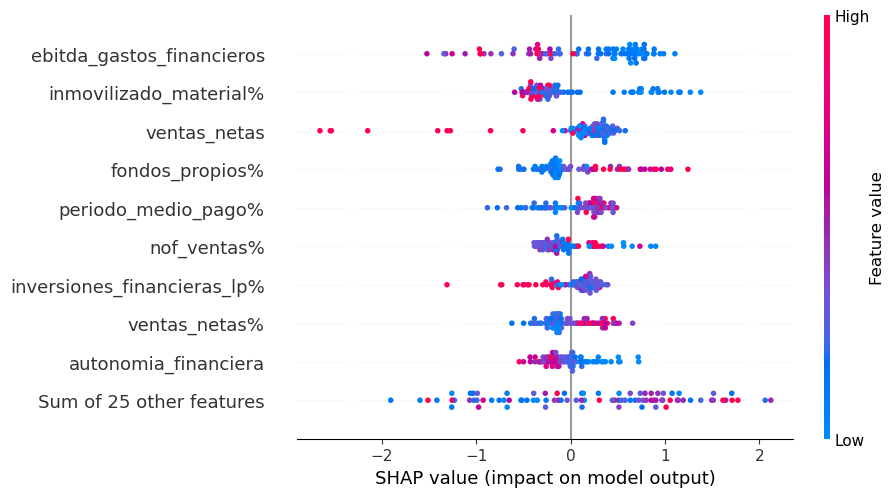

In [27]:
import shap
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# 1. Leer datos
df = pd.read_parquet("companies_T_anon.parquet")

# 2. Preprocesamiento (tus funciones)
df = preprocesar_datos(df)
df = seleccionar_variables(df, target_col="target_bin")

# 3. Separar X e y
y = df["target_bin"]
X = df.drop(columns=["target_bin"])

# 4. Balancear con SMOTE (sin paso CTGAN)
X_bal, y_bal = SMOTE(random_state=1).fit_resample(X, y)

# Train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X_bal, y_bal, test_size=0.2, stratify=y_bal, random_state=1
)

xgb = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    eval_metric="logloss",
    random_state=1,
)
xgb.fit(X_train, y_train)

# ---------- SHAP 0.45+  ----------
explainer   = shap.TreeExplainer(xgb)
shap_values = explainer(X_test)        # Explanation de forma (n_samples, n_features)

# Beeswarm para TODAS las instancias (correcto)
shap.plots.beeswarm(shap_values, max_display=10)       # sin [:, 1]

# (Opcional) force_plot para una sola fila
# shap.plots.force(shap_values[0])     # índice 0 como ejemplo


Tras la lectura y preprocesamiento del conjunto de datos anonimizado, se ha aplicado un procedimiento de sobremuestreo mediante SMOTE para abordar el desequilibrio de clases inherente al problema de credit scoring binario. Posteriormente, se ha dividido el conjunto resultante en subconjuntos de entrenamiento y prueba, asegurando una distribución estratificada de la variable objetivo target_bin. Para la modelización, se ha entrenado un clasificador XGBoost con una configuración estándar (100 árboles, profundidad máxima de 6, tasa de aprendizaje de 0.1), utilizando como métrica interna la log-loss y fijando una semilla para garantizar la reproducibilidad.

Una vez entrenado el modelo, se ha procedido a su interpretación mediante el framework SHAP (SHapley Additive exPlanations), específicamente utilizando el objeto TreeExplainer, optimizado para modelos basados en árboles. Los valores SHAP se han calculado sobre el conjunto de prueba, obteniéndose una matriz tridimensional que permite descomponer, para cada instancia, la contribución de cada variable al logit de la predicción. La visualización generada mediante el gráfico tipo beeswarm proporciona una representación sintetizada de dicha influencia: en el eje vertical se ordenan las variables por impacto medio absoluto, mientras que en el eje horizontal se representa el valor SHAP individual. El color de cada punto codifica la magnitud relativa del valor de la variable (de bajo en azul a alto en rojo), lo cual permite inferir tanto la dirección como la intensidad del efecto de cada predictor sobre la probabilidad de pertenencia a la clase positiva (riesgo ≥ 7).

Esta visualización ha revelado, por ejemplo, que valores elevados de inmovilizado_material% o ebitda_gastos_financieros tienden a asociarse con un incremento en el riesgo crediticio estimado por el modelo, mientras que mayores niveles de autonomia_financiera o fondos_propios% ejercen un efecto mitigador. Esta interpretación local-global resulta esencial no solo para la validación del comportamiento del modelo, sino también para la generación de insights financieros con valor operativo.

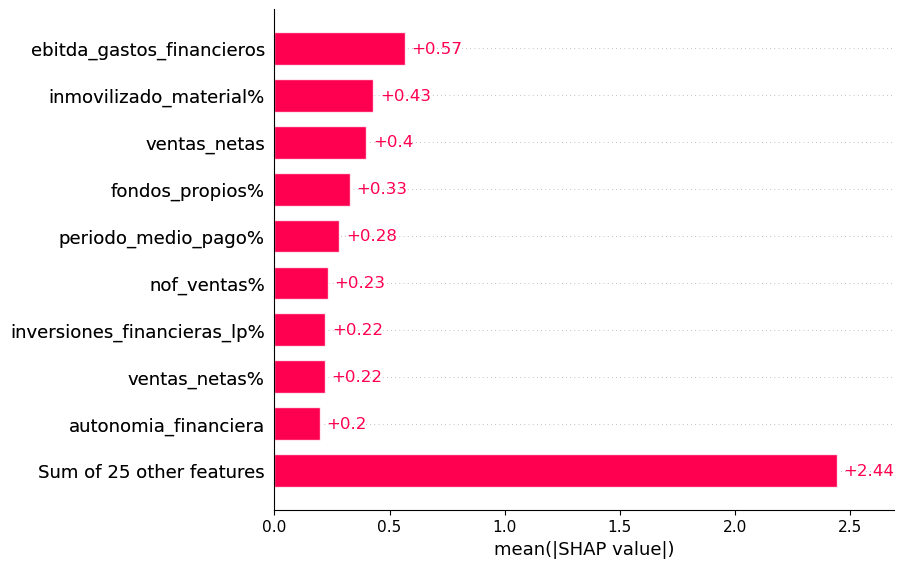

In [29]:
shap.plots.bar(shap_values, max_display=10)

Además del análisis individualizado mediante el gráfico beeswarm, se ha generado una visualización complementaria mediante el gráfico de barras de valores SHAP medios absolutos (mean(|SHAP value|)), lo cual permite cuantificar de forma global la importancia relativa de cada predictor en la toma de decisiones del modelo. En este gráfico, cada barra representa el impacto promedio de una variable sobre la predicción del clasificador XGBoost, sin considerar la dirección (positiva o negativa), sino únicamente la magnitud de su contribución.

Se observa que las variables ebitda_gastos_financieros, inmovilizado_material% y ventas_netas constituyen los tres factores con mayor peso explicativo, con valores medios de 0.57, 0.43 y 0.40 respectivamente. Esto sugiere que estas variables financieras son sistemáticamente relevantes para la estimación del riesgo crediticio en el conjunto de prueba. Por otro lado, variables como autonomia_financiera o ventas_netas% también presentan contribuciones significativas, aunque de menor magnitud. La suma del impacto agregado de las 25 variables restantes es sustancial (+2.44), lo cual indica que, si bien algunas características destacan de forma clara, el modelo también distribuye parte de la información predictiva en un conjunto amplio y heterogéneo de indicadores financieros. Esta dispersión controlada de la importancia puede ser interpretada como señal de robustez en la modelización, evitando una excesiva dependencia de un único predictor.

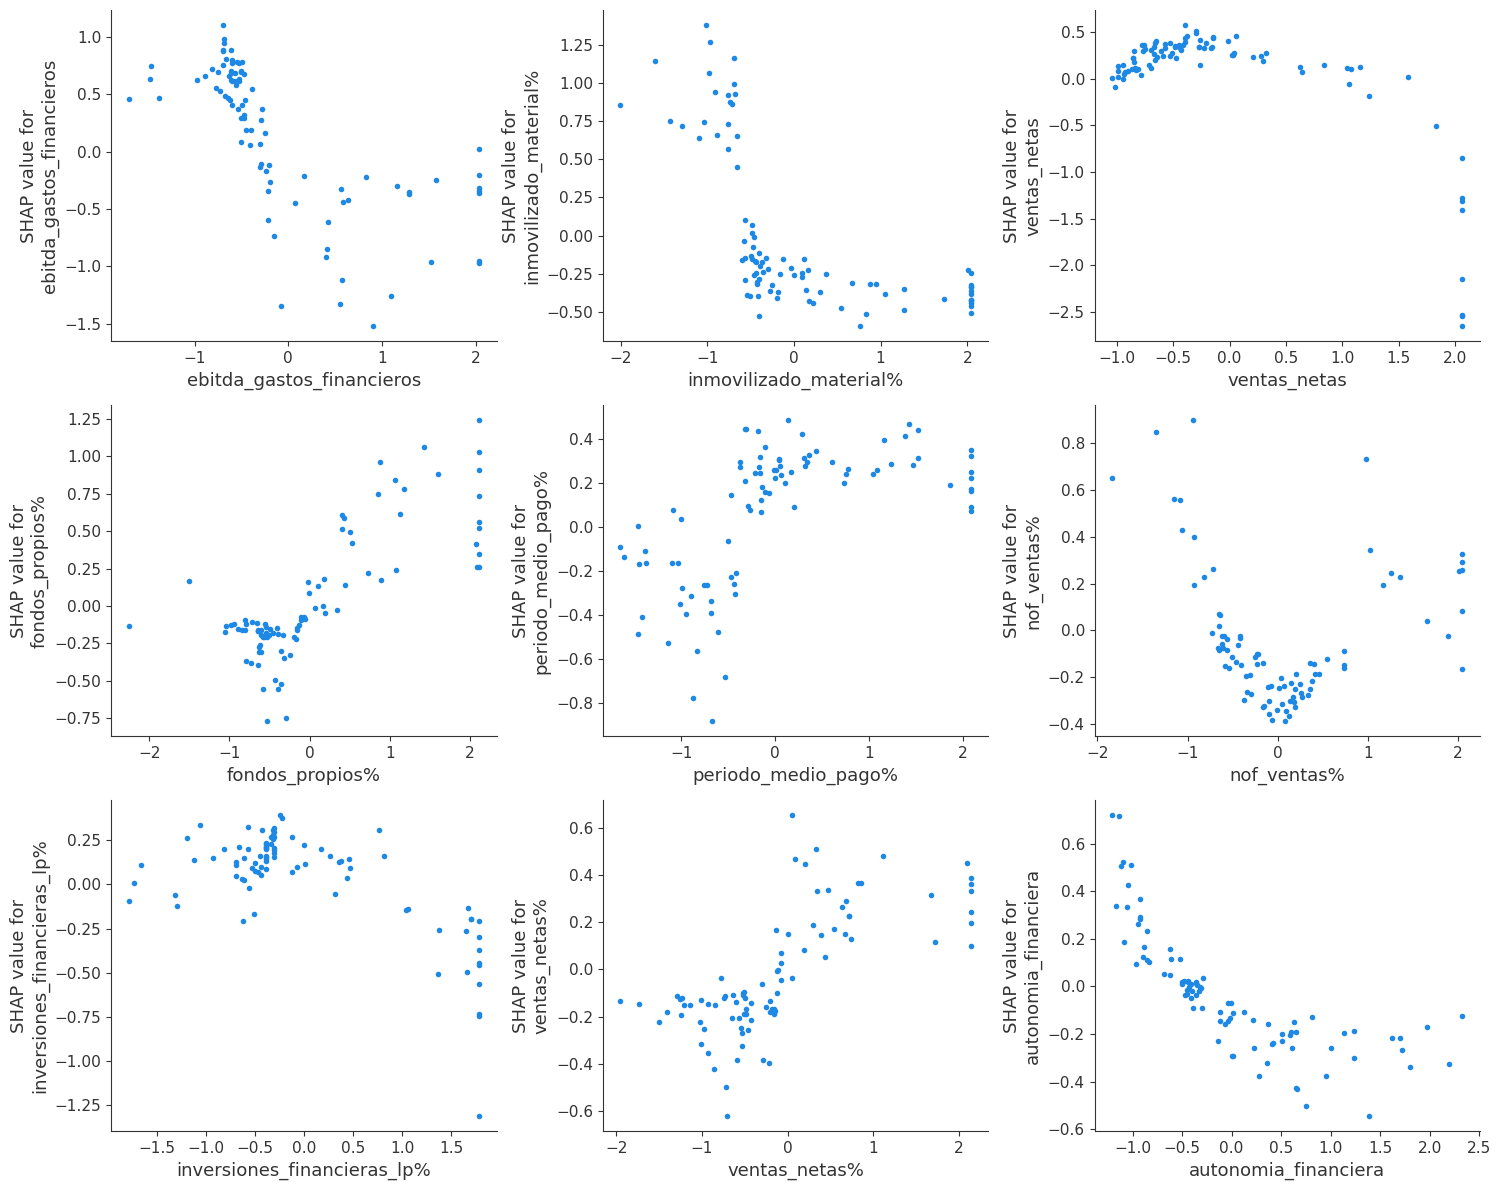

In [30]:
import shap
import numpy as np
import matplotlib.pyplot as plt
import math

# ---------- 1. obtener los valores SHAP como matriz ----------
# Si ya llamaste antes a explainer(X_test_df):
# shap_values = explainer(X_test_df)
# Asegúrate de tener shap_values a mano

shap_matrix = shap_values.values            # shape = (n_samples, n_features)

# ---------- 2. seleccionar las N variables más importantes ----------
n_features   = 9                # cambia si quieres más/menos
mean_abs_imp = np.abs(shap_matrix).mean(axis=0)
top_idx      = np.argsort(mean_abs_imp)[-n_features:][::-1]   # índices ordenados
feature_names = X_test_df.columns[top_idx]

# ---------- 3. preparar la parrilla de subplots ----------
cols  = 3
rows  = math.ceil(n_features / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
axes = axes.flatten()

# ---------- 4. dependence plots ----------
for i, feat in enumerate(feature_names):
    shap.dependence_plot(
        feat,
        shap_matrix,        # <- matriz SHAP
        X_test_df,
        ax=axes[i],
        interaction_index=None,   # evita interacciones automáticas
        show=False
    )

# ---------- 5. eliminar ejes vacíos ----------
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


Con el objetivo de explorar la relación funcional entre las variables predictoras y su impacto en la predicción del modelo, se han generado gráficos de dependencia SHAP para las diez variables más relevantes. En cada subgráfico se representa, en el eje horizontal, el valor observado de la variable, y en el eje vertical, su valor SHAP correspondiente, es decir, la contribución concreta de dicha variable a la predicción del modelo en cada instancia. Esta visualización permite identificar patrones no lineales, interacciones implícitas y posibles umbrales críticos que afectan la asignación de riesgo.

Los resultados evidencian relaciones distintas según la naturaleza económica de cada indicador. Por ejemplo, en el caso de ebitda_gastos_financieros, se observa un comportamiento abrupto a partir de ciertos valores negativos, sugiriendo un umbral de deterioro en la capacidad de cobertura financiera. En inmovilizado_material%, los valores altos tienden a tener una contribución negativa al riesgo (valores SHAP decrecientes), lo cual puede reflejar un exceso de capital inmovilizado. En cambio, ventas_netas muestra una relación invertida en forma de parábola invertida, con contribuciones más negativas (mayor reducción del riesgo) en niveles medios, pero aumento del riesgo en valores extremos.

De especial interés son los patrones decrecientes observados en autonomia_financiera y fondos_propios%, donde a mayor valor del indicador, menor contribución al riesgo crediticio, lo que concuerda con la interpretación financiera esperada: una mayor solvencia tiende a reducir la probabilidad de impago. Por otro lado, variables como nof_ventas% y ventas_netas% presentan relaciones más complejas o dispersas, lo que podría indicar interacciones no modeladas explícitamente o efectos no lineales difíciles de interpretar de forma aislada.

En conjunto, esta serie de gráficos permite no solo validar la coherencia económica del modelo, sino también ofrecer una base empírica sólida para la elaboración de políticas de decisión basadas en umbrales operativos.

In [33]:
import shap
shap.initjs()

# índice de la fila que quieres explicar
idx = 0

# usando plots.force (recomendado en la API nueva)
shap.plots.force(shap_values[idx])


Para interpretar de forma individualizada una predicción concreta del modelo, se ha generado una visualización local mediante SHAP force plot, en la cual se representa cómo cada variable ha contribuido a desplazar la predicción desde un valor base (promedio del modelo) hasta el valor final de la muestra evaluada. En este caso, la predicción final del modelo es f(x) = –1.46 en escala logit, lo que implica una probabilidad inferior al umbral de clasificación (riesgo reducido).

Las variables que empujan la predicción hacia valores más bajos (representadas en azul) son aquellas que reducen el riesgo crediticio estimado, como ventas_netas = 2.064, periodo_medio_pago% = –0.726, ebitda_gastos_financieros = 0.1693 o fondos_propios%. En contraste, las variables en rojo incrementan el riesgo estimado, actuando en sentido contrario: inmovilizado_material% = –0.6777, ventas_netas% = 0.3362 y fondos_propios% = 0.5218 han tenido un efecto adverso en esta observación concreta.

Esta descomposición aditiva permite al analista comprender de forma transparente por qué el modelo ha clasificado a esta entidad como de bajo riesgo, facilitando la trazabilidad y justificación de decisiones automatizadas en contextos sensibles como la concesión de crédito. Asimismo, permite detectar posibles conflictos entre indicadores financieros que, aun perteneciendo a una misma área (por ejemplo, ingresos vs. ratios de eficiencia), ejercen influencias opuestas sobre la decisión final.


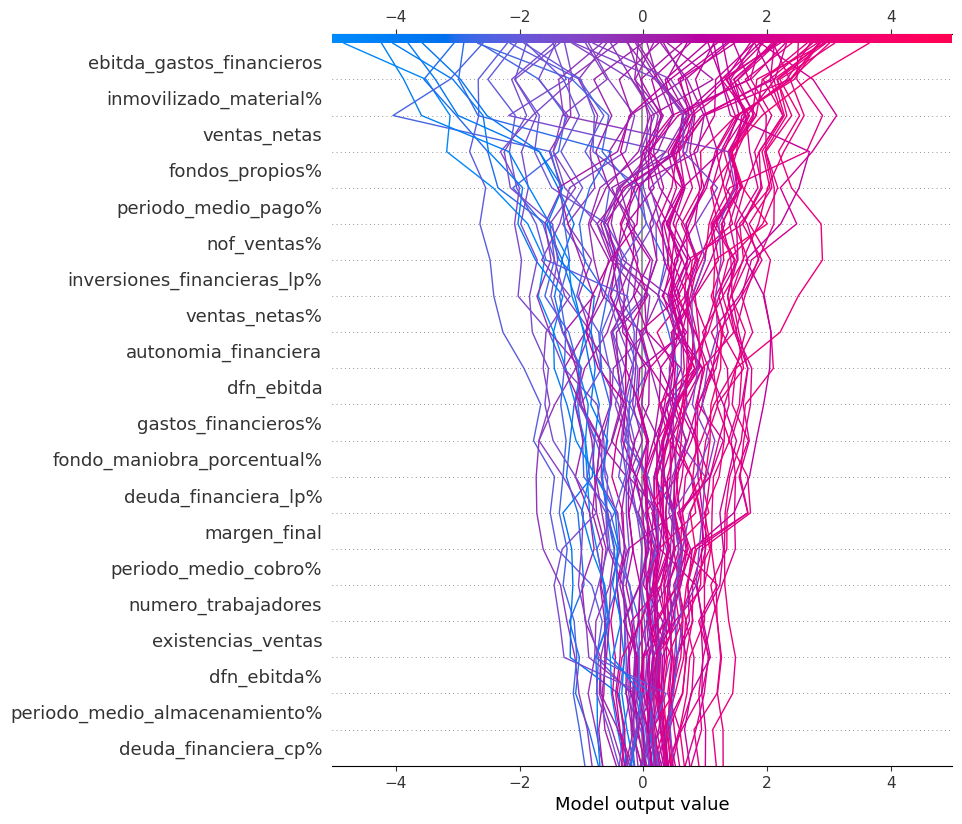

In [35]:
import shap

shap.decision_plot(
    explainer.expected_value,         # Valor base (escalar, binario)
    shap_values.values,               # Matriz SHAP
    X_test_df                         # Features originales
)


Para analizar la evolución de las predicciones del modelo a través de múltiples observaciones, se ha generado un SHAP decision plot, el cual permite visualizar de forma conjunta la trayectoria de las decisiones del modelo desde el valor base hasta la predicción final. Cada línea representa una muestra del conjunto de prueba, y el desplazamiento horizontal refleja la acumulación de valores SHAP (impacto aditivo) de cada variable ordenada por importancia descendente.

Este tipo de visualización resulta especialmente útil para detectar trayectorias recurrentes o divergentes en la toma de decisiones del modelo, identificando qué variables tienden a provocar mayores desplazamientos hacia una predicción positiva (riesgo elevado) o negativa (riesgo bajo). Se observa, por ejemplo, que variables como ebitda_gastos_financieros, inmovilizado_material% y ventas_netas introducen una variabilidad significativa en los primeros pasos del proceso decisorio, lo que confirma su relevancia estructural en el modelo. Además, el patrón de curvatura y densidad de líneas muestra que estas variables tienden a discriminar entre grupos de observaciones con predicciones extremas (positivo o negativo), mientras que variables menos relevantes, como deuda_financiera_cp% o periodo_medio_almacenamiento%, aparecen en etapas finales con efectos más marginales.

El uso de esta visualización refuerza la interpretabilidad global del modelo, al ofrecer una perspectiva secuencial y acumulativa de cómo cada característica va modificando progresivamente el output del modelo, contribuyendo así a una toma de decisiones más transparente y trazable en entornos regulados como el análisis crediticio.


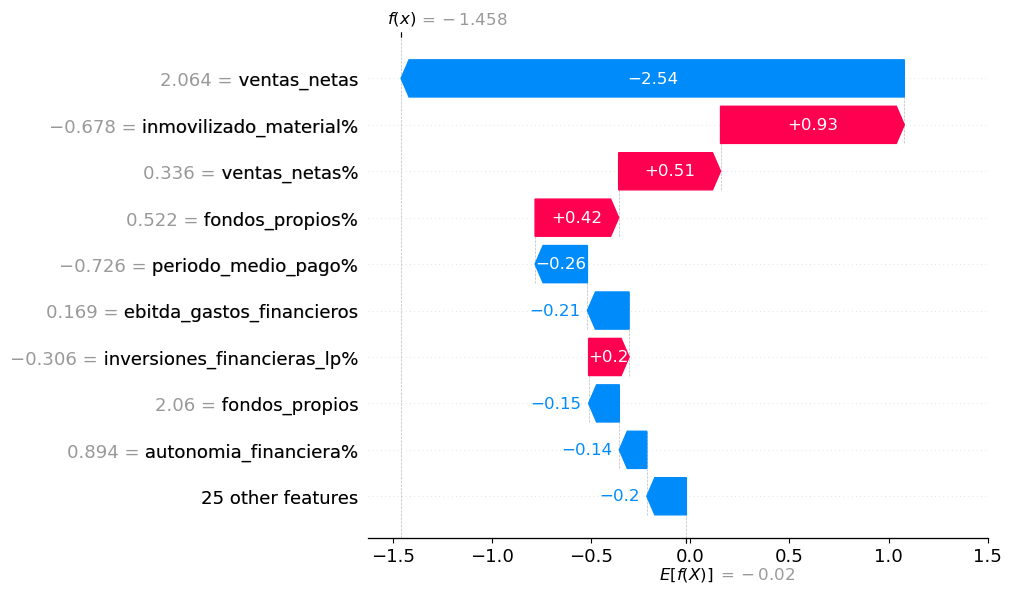

In [36]:
idx = 0   # índice de la muestra a explicar

# Waterfall moderno (recomendado)
shap.plots.waterfall(shap_values[idx])


Para analizar con mayor granularidad la predicción del modelo sobre una observación individual, se ha generado una gráfica de tipo waterfall mediante valores SHAP correspondiente a la muestra número 0. Este tipo de visualización permite descomponer de forma secuencial la predicción final del modelo f(x)=−1,458 a partir del valor base (esperanza de predicción sobre todo el conjunto, E[f(X)]=−0,02), mostrando cómo cada característica ha contribuido positiva o negativamente a esa desviación.

En esta instancia particular, los mayores efectos reductores sobre el riesgo (coloreados en azul) corresponden a un valor elevado de ventas_netas = 2.064, que disminuye fuertemente la predicción en –2.54 puntos, y a otros predictores como periodo_medio_pago%, ebitda_gastos_financieros, autonomia_financiera% y fondos_propios, todos con contribuciones negativas adicionales. Por el contrario, algunas variables han incrementado la predicción hacia el riesgo, en especial inmovilizado_material% = –0.678 y ventas_netas% = 0.336, con efectos de +0.93 y +0.51, respectivamente.

Este desglose detallado permite inferir con claridad que la predicción negativa del modelo (asociada a bajo riesgo crediticio) ha sido impulsada principalmente por el alto volumen de ventas netas y otros indicadores de solvencia. Por tanto, la decisión del modelo resulta explicable y coherente desde el punto de vista financiero. Este tipo de interpretabilidad local resulta esencial tanto para la auditoría interna de los sistemas de decisión automatizados como para el cumplimiento de requisitos regulatorios sobre explicabilidad, como los establecidos en el Reglamento General de Protección de Datos (GDPR) de la Unión Europea.

### SHAP (MLP)

A continuación, se comparan los valores SHAP generados para dos modelos: XGBoost y MLP (Multi-Layer Perceptron). Esta comparación permite analizar no solo el rendimiento cuantitativo de ambos enfoques, sino también las diferencias en la relevancia atribuida a las variables explicativas, lo cual es fundamental para seleccionar un modelo que sea no solo preciso, sino también interpretable y coherente con la lógica financiera del problema.

XGBoost es un modelo de árboles de decisión optimizado mediante técnicas de boosting. A diferencia de algoritmos como Random Forest, que combinan árboles independientes en paralelo, XGBoost entrena árboles de forma secuencial, donde cada árbol corrige los errores cometidos por los anteriores. Esta arquitectura permite capturar relaciones no lineales y efectos de interacción complejos con alta eficacia, manteniendo al mismo tiempo una estructura jerárquica que facilita la interpretación. Además, XGBoost es compatible con el uso de TreeExplainer de SHAP, lo que permite obtener valores explicativos precisos y eficientes computacionalmente.

En contraste, el modelo MLP se basa en una red neuronal densa, en la que múltiples capas ocultas intentan aproximar funciones altamente no lineales mediante combinaciones de activaciones neuronales. Aunque esta arquitectura ofrece una gran flexibilidad para modelar relaciones complejas entre variables, no genera reglas explícitas como los modelos de árbol. Por ello, su interpretación resulta más abstracta y dependiente de técnicas post-hoc como KernelExplainer, que, a diferencia de TreeExplainer, es más lento y menos exacto al proporcionar estimaciones basadas en aproximaciones por muestreo.

Desde el punto de vista interpretativo, los valores SHAP obtenidos con XGBoost tienden a reflejar de forma más clara y localizada el impacto de cada variable sobre la predicción, mientras que en MLP los efectos pueden estar más suavizados o distribuidos debido a las interacciones implícitas entre capas. Esta diferencia se refleja en los gráficos SHAP: en XGBoost se observan contribuciones más directas y consistentes, mientras que en MLP pueden aparecer patrones menos definidos o más sensibles a la escala y normalización de los datos.

Eliminando por baja varianza: ['cash_flow_antes_var']
Eliminando por alta correlacion: []
Distribución de clase sintética:
target_bin
0    160
1    140
Name: count, dtype: int64


`BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
100%|█████████████████████████████████████████| 153/153 [01:16<00:00,  2.00it/s]


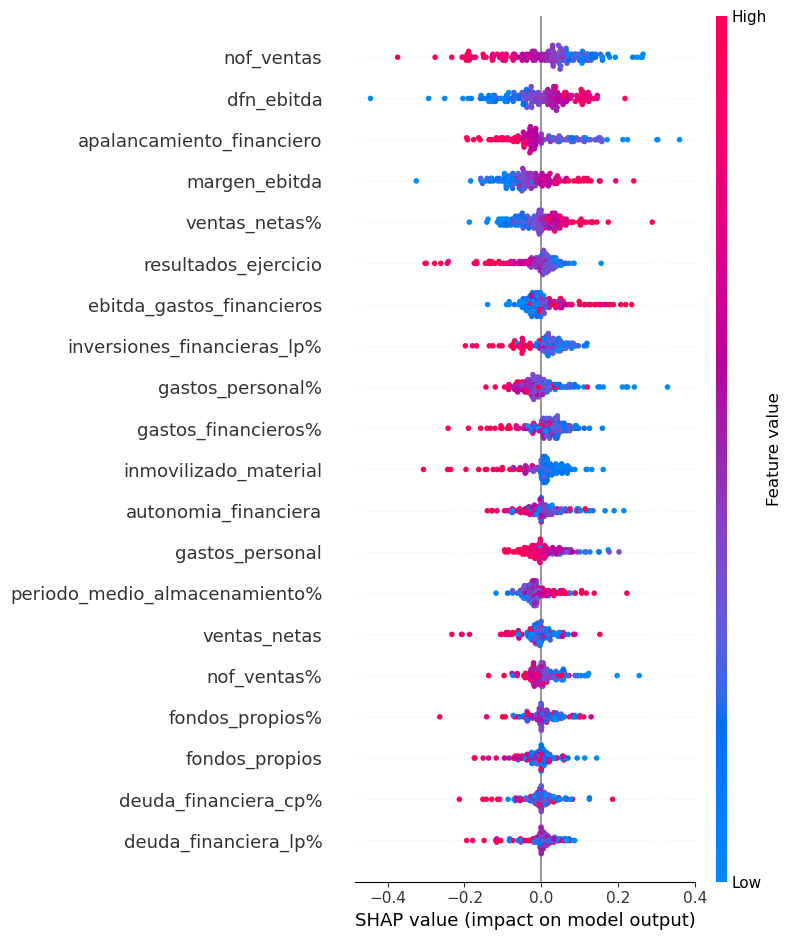

In [37]:
import shap
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score

# Leer datos
df = pd.read_parquet("companies_T_anon.parquet")
df = preprocesar_datos(df)
df = seleccionar_variables(df, target_col="target_bin")

# Separar X e y
y = df["target_bin"]
X = df.drop(columns=["target_bin"])

# CTGAN
X_ctgan, y_ctgan = generar_datos_ctgan(X, y)

# SMOTE
X_ctgan_smote, y_ctgan_smote = SMOTE(random_state=1).fit_resample(X_ctgan, y_ctgan)

# Train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_ctgan_smote, y_ctgan_smote, test_size=0.2, stratify=y_ctgan_smote, random_state=1
)

X_train_df = pd.DataFrame(X_train, columns=X.columns)
X_test_df = pd.DataFrame(X_test, columns=X.columns)

# Entrenar MLP
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=1)
mlp.fit(X_train_df, y_train)

# SHAP con KernelExplainer
explainer = shap.KernelExplainer(mlp.predict_proba, shap.sample(X_train_df, 100, random_state=1))
shap_values = explainer.shap_values(X_test_df)

# Summary plot (clase 1)
shap.summary_plot(shap_values[1], X_test_df)


La figura muestra el gráfico de resumen (summary plot) generado con SHAP para la clase positiva (riesgo elevado) del modelo MLPClassifier, utilizando el KernelExplainer. Este tipo de representación permite visualizar de manera sintética la importancia y el efecto direccional de cada variable sobre la predicción del modelo.

En el eje vertical se presentan las variables ordenadas según su impacto promedio absoluto en la predicción. Cada punto representa una observación del conjunto de prueba, y su posición horizontal refleja el valor SHAP, es decir, la contribución de esa variable en esa instancia específica al resultado del modelo. El color codifica el valor original de la variable: en azul para valores bajos y en rojo para altos.

A diferencia de modelos basados en árboles, el comportamiento en MLP es más difuso, debido a la naturaleza distribuida de los pesos y a la forma en que se combinan múltiples entradas a través de capas ocultas. Esto se refleja en la dispersión más homogénea de los puntos y en la menor magnitud de los valores SHAP individuales. Por ejemplo, variables como nof_ventas, dfn_ebitda y apalancamiento_financiero se destacan como las más influyentes, aunque sus contribuciones oscilan en un rango estrecho (aproximadamente entre –0.4 y +0.4), lo cual sugiere un modelo más conservador o regularizado en su toma de decisiones.

Además, la gráfica revela relaciones complejas: por ejemplo, en apalancamiento_financiero, los valores altos (rojos) tienden a incrementar el riesgo predicho (valores SHAP positivos), lo cual es coherente con su interpretación financiera. En cambio, otras variables como autonomia_financiera o fondos_propios muestran patrones menos definidos, con puntos rojos y azules dispersos en ambos extremos, lo que indica posibles interacciones o efectos no lineales difíciles de interpretar de forma aislada.

Este tipo de visualización es fundamental para evaluar si el modelo MLP, pese a su menor interpretabilidad estructural, está aprendiendo patrones coherentes desde una perspectiva financiera, lo cual justifica su uso en contextos donde el rendimiento predictivo es prioritario, pero la trazabilidad sigue siendo necesaria.

100%|█████████████████████████████████████████| 153/153 [00:14<00:00, 10.81it/s]


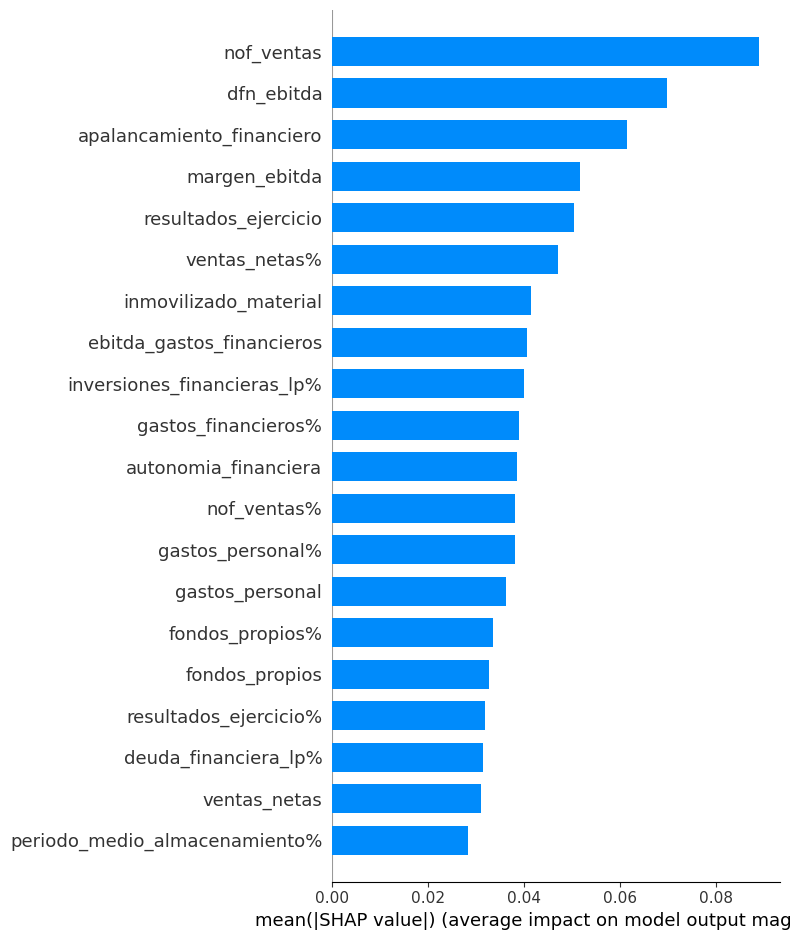

In [38]:
import shap

explainer = shap.KernelExplainer(mlp.predict_proba, shap.sample(X_train, 100))
shap_values = explainer.shap_values(X_test_df, nsamples=100)

# Para clasificación binaria:
shap.summary_plot(shap_values[1], X_test_df, plot_type="bar")


Además del análisis detallado por observación, se ha generado un gráfico de barras con los valores SHAP promedio absolutos para el modelo MLPClassifier, entrenado sobre datos aumentados mediante CTGAN y balanceados con SMOTE. Este gráfico permite identificar, de forma agregada, qué variables han tenido mayor impacto medio sobre la salida del modelo, independientemente de la dirección del efecto.

Los resultados muestran que las variables más influyentes han sido nof_ventas, dfn_ebitda y apalancamiento_financiero, seguidas de indicadores de rentabilidad como margen_ebitda y resultados_ejercicio. Esto sugiere que el modelo MLP, pese a su estructura no lineal y distribuida, ha logrado identificar correctamente variables financieras clave asociadas al riesgo crediticio. Otras variables relevantes, aunque con menor peso relativo, incluyen ratios clásicos de estructura (inmovilizado_material, autonomia_financiera), liquidez (inversiones_financieras_lp%) y eficiencia operativa (gastos_personal%, ventas_netas%).

En comparación con modelos basados en árboles como XGBoost, se observa que el MLP tiende a repartir la importancia entre un número más amplio de variables, con una menor dispersión de valores SHAP extremos. Esta característica puede interpretarse como un indicio de regularización interna y menor propensión al sobreajuste, pero también de una interpretabilidad menos localizada, lo cual refuerza la necesidad de utilizar herramientas post-hoc como SHAP para su análisis.

Este tipo de visualización es útil para construir un ranking de variables clave a considerar en futuras auditorías de riesgo o incluso como base para estrategias de selección de atributos (feature selection) orientadas a modelos más simples o explicables.


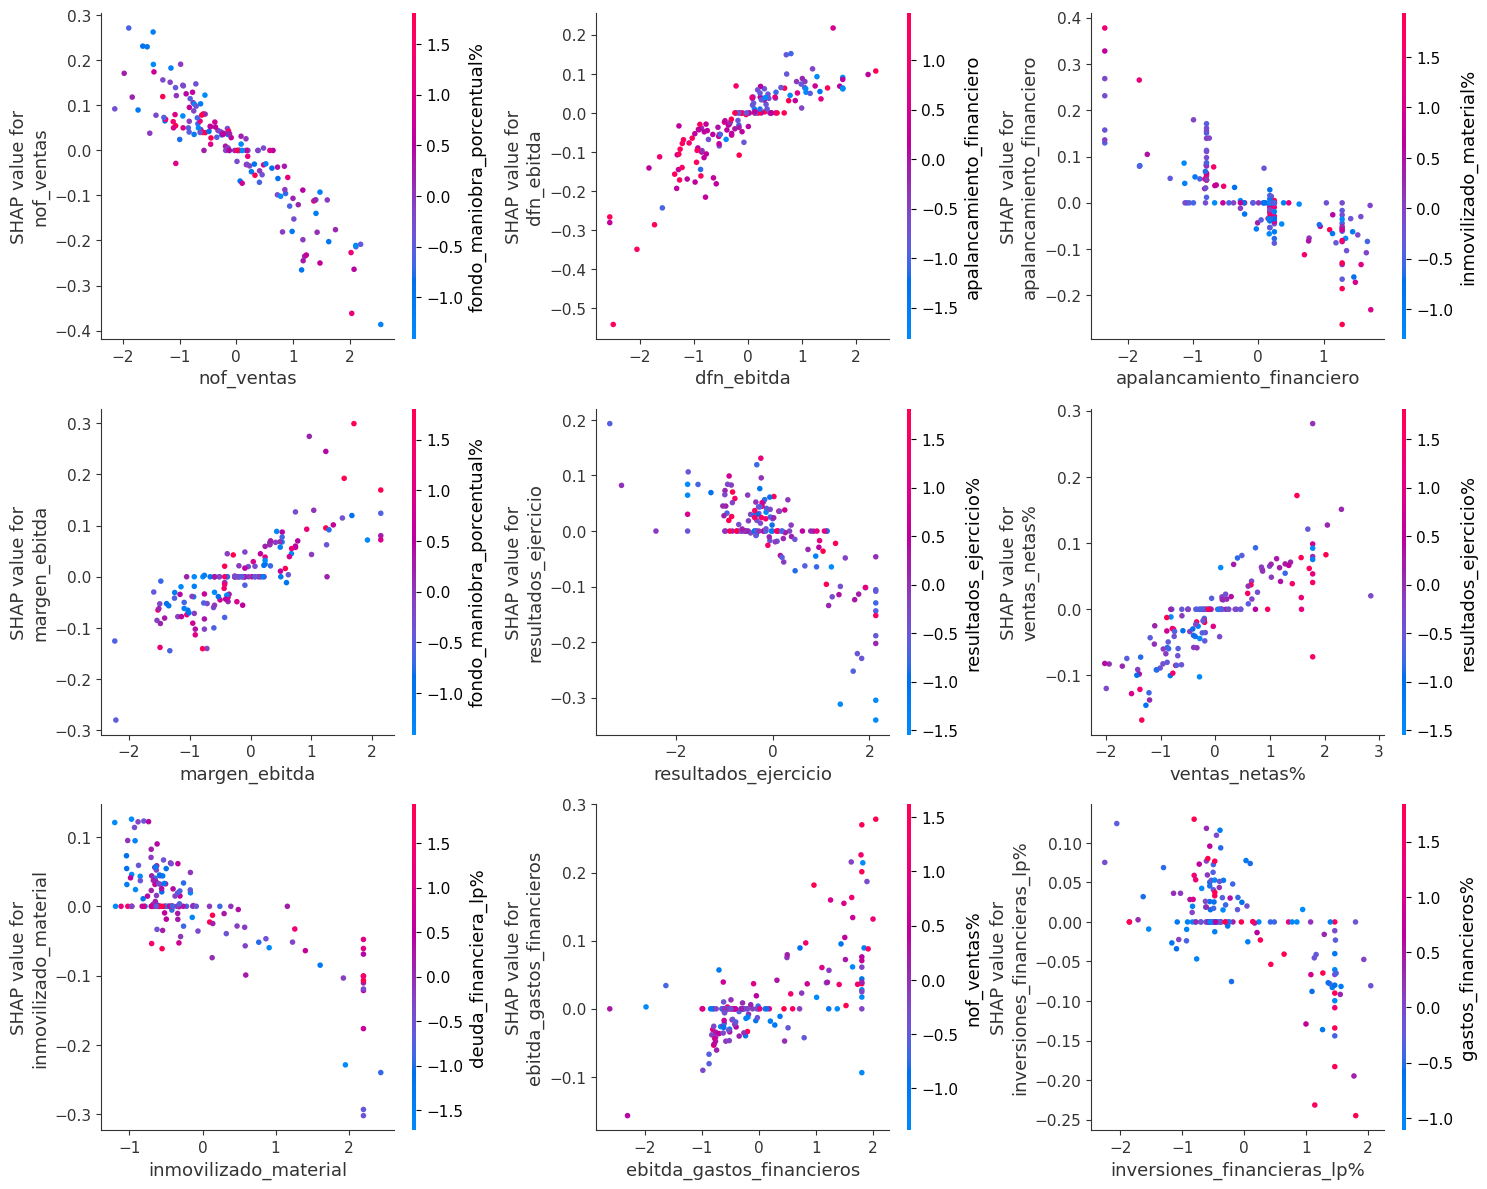

In [39]:
# Número de variables a mostrar
n_features = 9
shap_vals_class1 = shap_values[1]  # SHAP para clase positiva
top_features = np.argsort(np.abs(shap_vals_class1).mean(0))[-n_features:][::-1]
feature_names = X_test_df.columns[top_features]

# Crear subplots
cols = 3
rows = math.ceil(n_features / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*4))
axes = axes.flatten()

for i, feature in enumerate(feature_names):
    shap.dependence_plot(
        feature,
        shap_vals_class1,
        X_test_df,
        ax=axes[i],
        show=False
    )

# Eliminar subplots vacíos
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


Para profundizar en el análisis interpretativo del modelo MLPClassifier, se han generado gráficos de dependencia SHAP para las principales variables identificadas en el análisis global. Cada subgráfico muestra, para una característica concreta, la relación entre su valor observado (eje X) y su contribución al output del modelo (eje Y), es decir, su valor SHAP. El color de los puntos representa una segunda variable relevante, lo que permite identificar efectos de interacción.

En varios casos se observan relaciones monótonas y coherentes con la lógica financiera: por ejemplo, nof_ventas presenta una clara relación decreciente, en la que un mayor número de ventas se asocia con menor riesgo (valores SHAP negativos). Lo mismo ocurre con dfn_ebitda y apalancamiento_financiero, cuyas contribuciones positivas aumentan con su valor, reflejando mayor riesgo percibido a medida que aumenta la carga financiera.

Otras variables como margen_ebitda y ventas_netas% muestran relaciones crecientes con el valor SHAP, indicando que niveles más altos de rentabilidad contribuyen positivamente a la predicción del riesgo, un resultado que puede parecer contraintuitivo y que debe interpretarse en función de posibles interacciones u outliers.

En algunos gráficos se evidencian zonas de saturación o comportamiento no lineal, como en inmovilizado_material, donde se observa un cambio brusco en el valor SHAP a partir de cierto umbral. Asimismo, la presencia de bandas horizontales en varias gráficas sugiere efectos de cuantización o regiones planas dentro del espacio latente del modelo, característico de redes neuronales entrenadas con regularización o bajo ciertas condiciones de convergencia.

Este análisis gráfico permite visualizar cómo el modelo MLP distribuye sus decisiones a lo largo del espacio de entrada y proporciona evidencia de que las variables identificadas como importantes por los valores SHAP globales también tienen un comportamiento explicable a nivel local. No obstante, la suavidad y dispersión observadas reafirman que, a diferencia de modelos como XGBoost, el MLP no tiende a generar reglas explícitas ni puntos de corte nítidos, lo que limita parcialmente su interpretabilidad directa.

In [17]:
shap.initjs()
shap.force_plot(
    explainer.expected_value[1],     # Valor esperado para clase 1
    shap_values[1][0],               # SHAP values de la fila 0, clase 1
    X_test_df.iloc[0]                # Mismos features de esa fila
)


Para ilustrar el razonamiento del modelo MLPClassifier en una instancia individual, se ha generado un SHAP force plot, que representa de forma aditiva cómo las variables de entrada han contribuido a modificar la predicción del modelo desde el valor base (base value=0.5395base value=0.5395) hasta la salida final para esa muestra (f(x)=0.046).

En este caso, el modelo ha producido una predicción próxima al umbral de decisión (en probabilidades, alrededor del 51%), lo cual sugiere una situación financiera ambigua o intermedia. Las variables que empujan la predicción hacia una mayor probabilidad de riesgo (color rojo) incluyen: ventas_netas% = 1.496, autonomia_financiera% = -0.6178 y otra variable (cortada en el gráfico) que ha aportado +1.469 puntos al logit. Estas variables han contrarrestado parcialmente los efectos reductores del riesgo ejercidos por fondos_propios% = 1.374, ebitda_gastos_financieros = –2.298, inversiones_financieras_lp% = 1.003, y margen_ebitda = –0.908, que aparecen representadas en azul.

Esta descomposición permite identificar tensiones internas en el perfil financiero del caso analizado: mientras algunos indicadores sugieren solvencia y capacidad operativa (por ejemplo, EBITDA positivo y buena rentabilidad), otros como una baja autonomía financiera o una elevada proporción de ventas respecto a activos pueden estar elevando el riesgo percibido por la red neuronal.

A diferencia del force plot generado con XGBoost, aquí se observa una mayor superposición de efectos sutiles y dispersos, lo que es característico de modelos densos como el MLP, donde las decisiones no se apoyan en reglas estructuradas sino en patrones latentes distribuidos. Aun así, la trazabilidad proporcionada por SHAP permite explicar decisiones incluso en modelos opacos, reforzando su aplicabilidad en contextos regulados como el análisis de crédito.

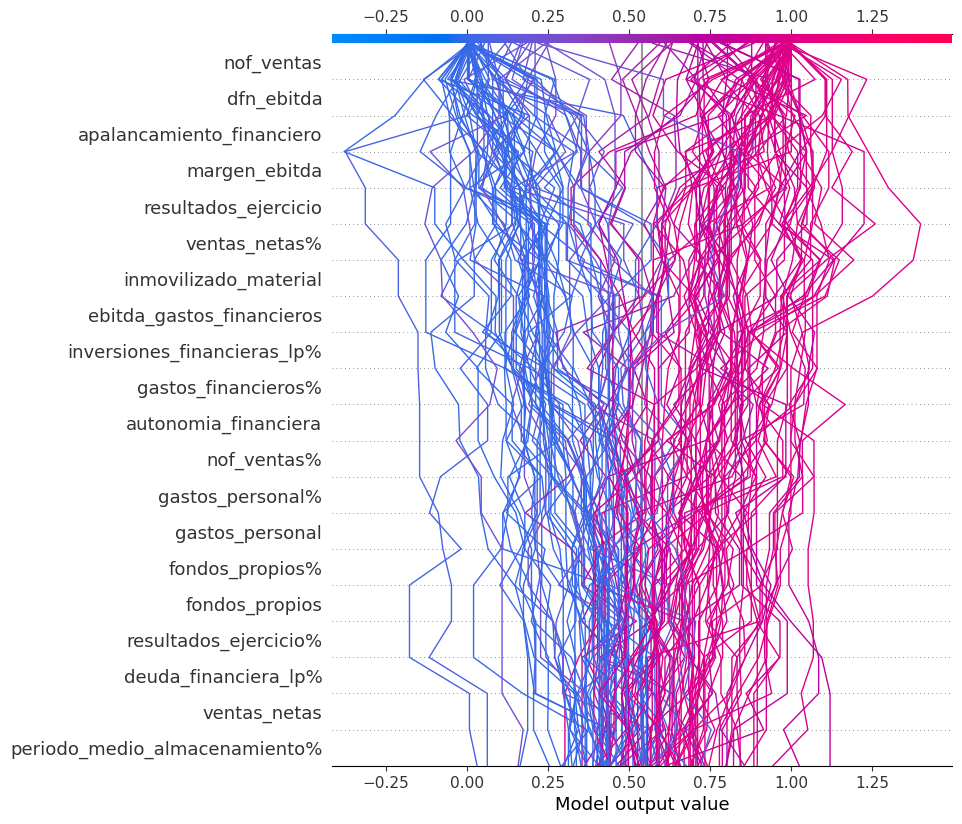

In [18]:
shap.decision_plot(
    explainer.expected_value[1],   # Para clase 1
    shap_values[1],                # SHAP values para clase 1 (forma: [n_samples, n_features])
    X_test_df                      # Features
)


El gráfico SHAP decision plot para el modelo MLPClassifier permite visualizar cómo se acumulan las contribuciones de cada variable financiera en la predicción de riesgo para múltiples observaciones. Se observa que variables como nof_ventas, dfn_ebitda y apalancamiento_financiero generan una fuerte divergencia inicial en las trayectorias, determinando desde etapas tempranas si una empresa será clasificada como de alto o bajo riesgo. Indicadores como margen_ebitda y autonomia_financiera actúan de forma consistente moderando la decisión, mientras que otras variables de menor impacto, ubicadas en posiciones finales, apenas alteran el resultado. Esta visualización, aplicada a un modelo de red neuronal, permite auditar y comprender las dinámicas internas del modelo, identificando qué patrones financieros provocan la clasificación final, a pesar de la complejidad inherente a las redes densas.

### Conclusión

Como conclusión general, los resultados experimentales muestran que el rendimiento del modelo depende significativamente tanto del algoritmo de aprendizaje como de la estrategia de balanceo aplicada. En términos de rendimiento predictivo, el mejor resultado global se ha obtenido con el modelo XGBoost entrenado sobre datos balanceados mediante SMOTE, alcanzando una puntuación F1 de 0.77. Este modelo ha superado de forma consistente a otros algoritmos en distintos escenarios, lo que confirma su robustez y adaptabilidad al problema de clasificación binaria en el contexto de credit scoring. Por otro lado, el modelo MLP ha mostrado también un rendimiento competitivo, especialmente sobre el dataset generado con SMOTE + CTGAN, donde ha alcanzado un F1 de 0.76, evidenciando su capacidad de generalización cuando se dispone de datos sintéticos enriquecidos y balanceados.

En cuanto a la interpretabilidad, el análisis mediante valores SHAP ha revelado diferencias notables entre ambos enfoques. Mientras que XGBoost, gracias a su estructura basada en árboles de decisión, ofrece explicaciones más localizadas, directas y coherentes con la lógica financiera (por ejemplo, identificando ventas_netas, fondos_propios% y inmovilizado_material% como factores clave), el modelo MLP presenta patrones más suaves y distribuidos, con contribuciones más sutiles y difíciles de aislar. No obstante, mediante herramientas como KernelExplainer y gráficos como summary plot, dependence plot y force plot, ha sido posible auditar también las decisiones del MLP, lo que refuerza su viabilidad en entornos donde la precisión predomina, pero la trazabilidad sigue siendo necesaria.

En conjunto, la combinación de modelos explicables y potentes, junto con técnicas de generación y balanceo de datos como SMOTE y CTGAN, permite construir sistemas predictivos sólidos, transparentes y adaptables a distintos escenarios del análisis de riesgo financiero. El uso de herramientas interpretativas como SHAP resulta fundamental para garantizar no solo la eficacia del modelo, sino también su aceptación en contextos profesionales y regulatorios.